In [1]:
from IPython.display import Image
import torch.nn as nn
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import math

# Transformer

Вероятный взгляд, как придумывался Transformer.

### Look up table

Есть некоторая таблица, в этой таблице есть ключи (keys) и значения (values). $\newline$

<div style="float: left;">

| keys | values |
|:---:|:---:|
| k1 | v1 |
| k2 | v2 |
|...|...|

</div>

Допустим, у нас есть запрос $q$, тогда:

Если $q = k_i$ $⇒$ выдаем $r = v_i$.

Индикаторная функция: 

$$
I(a) = 
\begin{cases} 
  1 & \text{если } a = true \\
  0 & \text{если } a = false 
\end{cases}
$$

Тогда в виде формулы можно записать:

$$
r\,(q) = \sum_{i=1}^n I(q=k_i) \cdot v_i
$$

Все значения умножатся на 0, кроме одного. Предполагается, что ключи уникальны, поэтому только для одного элемента условие будет выполняться.

Недостатки такого подхода:

1. `Receptive field = 1`, так как благодаря индикаторной функции каждый раз мы смотрим только на один элемент, а хотелось бы учитывать все. $\newline$

2. `Необучаемые параметры`. Производную по $v_i$ можно спокойно посчитать, а производная по $q$ и $k_i$ не пройдет, так как у индикаторной функции производная везде равна 0 или не существует.

Получился слишком строгий и негибкий механизм.

Пусть теперь

$$r\,(q) = \sum_{i=1}^n δ_i \cdot v_i$$  

где $\sum_{i=1}^n δ_i = 1$ и $δ_i ≥ 0$.

Но что если эта единица не будет сконцентрирована в одной $δ_i$, как в случае индикаторной функции, а будет размазана по всем $δ_i$.

Функция $δ_i\,(q, k_1, k_2, \,...\, k_i, \,...\, k_n)$ зависит от запроса $q$ и от всех ключей $k_i$, $∀i∈[1, n]$. 

Получается, нам нужно найти такую функцию $δ_i$, чтобы градиенты для этой функции по $q$ и $k_j$ не были равны 0.

$$∇_q\, δ_i ≠ 0$$

$$∇_{k_j}\, δ_i ≠ 0$$

Но все это нужно сделать так, чтобы сохранилась логика **Look up table**: 

- Но теперь логика будет не жесткая, как раньше: $q = k_i$ $⇒$ выдаем $r = v_i$. $\newline$

- А такая: если $q$ похож на $k_i$ $⇒$ выдаем $r$ похож на $v_i$.

В качестве такой функции можно взять скалярное произведение двух векторов.

$$\langle \vec{q}, \vec{k} \rangle = \sum_{i=1}^n q_i \cdot k_i = \vec{q}^T \vec{k}$$ 

При этом выполняется условие: $\vec{q}^T \vec{k}_i > \vec{q}^T \vec{k}_j ⇒ δ_i > δ_j$.

Получаем $(\vec{q}^T \vec{k}_1, \vec{q}^T \vec{k}_2, ..., \vec{q}^T \vec{k}_n) = (δ_1, δ_2, ..., δ_n)$.

Но ведь при таком подходе не выполняются условия $\sum_{i=1}^n δ_i = 1$ и $δ_i ≥ 0$.

Тут нам пригождается функция `Softmax`.

$$
Softmax \,(\vec{z}) = \left(\frac{e^{\,z_1}}{\sum_{i=1}^{n}{e^{\,z_i}}}, \frac{e^{\,z_2}}{\sum_{i=1}^{n}{e^{\,z_i}}}, ..., \frac{e^{\,z_n}}{\sum_{i=1}^{n}{e^{\,z_i}}}\right);
$$

Теперь получаем $\vec{δ} = (δ_1, δ_2, ..., δ_n) = Softmax\,\left(\vec{q}^T \vec{k}_1, \vec{q}^T \vec{k}_2, ..., \vec{q}^T \vec{k}_n\right)$.

Теперь все условия выполняются, но есть один нюанс.

Пусть $\vec{q}, \vec{k} ∈ \mathbb{R}^d$

$$\vec{q}^T \vec{k} = \sum_{j=1}^d q_j \cdot k_j$$

Скалярное произведение векторов имеет некую дисперсию и эта дисперсия меняется, если менять размерность векторов $d$, а изменение дисперсии в свою очередь влияет на значения от функции `Softmax`. Чтобы убрать эту зависимость, нужно разделить каждое скалярное произведение $\vec{q}^T \vec{k}_i$ на $\sqrt{d}$.

Получаем:

$$
SDPA\left(\vec{q}, k, v\right) = \sum_{i=1}^n δ_i \cdot \vec{v}_i\,;
$$

$$
\vec{δ} = Softmax\,\left(\frac{\vec{q}^T \vec{k}_1}{\sqrt{d}}, \frac{\vec{q}^T \vec{k}_2}{\sqrt{d}}, ..., \frac{\vec{q}^T \vec{k}_n}{\sqrt{d}}\right);
$$

Мы получили формулу `SDPA (Scaled Dot-Product Attention)` для одного запроса, которому на вход подаются:

- Запрос $\,\vec{q}\,;$ $\newline$

- Ключи $k: \vec{k}_1, \vec{k}_2, \,...\,, \vec{k}_n\,;$ $\newline$

- Значения $v: \vec{v}_1, \vec{v}_2, \,...\,, \vec{v}_n\,;$ 

**SDPA для нескольких запросов**:

Пусть теперь у нас есть $m$ запросов: $\vec{q}_1, \vec{q}_2, \,...\,, \vec{q}_m$

Эти векторы запросов можно положить в матрицу $Q$ по строчкам:

$$
Q = \begin{pmatrix}
\vec{q}^T_1 \\
\vec{q}^T_2 \\
\vdots \\
\vec{q}^T_m
\end{pmatrix}
\,\,\,\text{размерность }(m \times d) $$ 

Также есть $n$ ключей и $n$ значений: 

- $\vec{k}_1, \vec{k}_2, \,...\,, \vec{k}_n$ $\newline$

- $\vec{v}_1, \vec{v}_2, \,...\,, \vec{v}_n$

Векторы ключей положим в матрицу $K$ по строкам. Векторы значений положим в матрицу $V$ также по строкам.

$$
K = \begin{pmatrix}
\vec{k}^T_1 \\
\vec{k}^T_2 \\
\vdots \\
\vec{k}^T_n
\end{pmatrix}
\,\,\,\text{размерность }(n \times d)$$

$$
V = \begin{pmatrix}
\vec{v}^T_1 \\
\vec{v}^T_2 \\
\vdots \\
\vec{v}^T_n
\end{pmatrix}
\,\,\,\text{размерность }(n \times d_V)$$

По количеству векторов ключи совпадают со значениями, по размерности векторов ключи совпадают с запросами.

Задача состоит в том, чтобы найти способ нахождения выходов для `SDPA` не по одному запросу, а в матричной форме для набора запросов.

Для начала нужно умножить строки запросов на столбцы ключей, но ключи расположены вдоль строк матрицы $K$, поэтому его надо транспонировать. 

Получаем: 

$$
Q K^T = \begin{pmatrix}
\vec{q}_1^T \vec{k}_1 & \vec{q}_1^T \vec{k}_2 & \vec{q}_1^T \vec{k}_3 & ... \\
\vec{q}_2^T \vec{k}_1 & \vec{q}_2^T \vec{k}_2 & \vec{q}_2^T \vec{k}_3 & ... \\
\vec{q}_3^T \vec{k}_1 & \vec{q}_3^T \vec{k}_2 & \vec{q}_3^T \vec{k}_3 & ... \\
... & ... & ... & ...
\end{pmatrix}
$$

Из этой матрицы очевидно, что функция `Softmax` будет **применяться по строкам**. Также каждое скалярной произведение делим на $\sqrt{d}$.

Получаем:

$$
Softmax\left(\frac{Q K^T}{\sqrt{d}}\right) = Softmax\begin{pmatrix}
\frac{\vec{q}_1^T \vec{k}_1}{\sqrt{d}} & \frac{\vec{q}_1^T \vec{k}_2}{\sqrt{d}} & \frac{\vec{q}_1^T \vec{k}_3}{\sqrt{d}} & ... \\
\frac{\vec{q}_2^T \vec{k}_1}{\sqrt{d}} & \frac{\vec{q}_2^T \vec{k}_2}{\sqrt{d}} & \frac{\vec{q}_2^T \vec{k}_3}{\sqrt{d}} & ... \\
\frac{\vec{q}_3^T \vec{k}_1}{\sqrt{d}} & \frac{\vec{q}_3^T \vec{k}_2}{\sqrt{d}} & \frac{\vec{q}_3^T \vec{k}_3}{\sqrt{d}} & ... \\
... & ... & ... & ...
\end{pmatrix}=\begin{pmatrix}
δ_1(\vec{q}_1) & δ_2(\vec{q}_1) & δ_3(\vec{q}_1) & ... \\
δ_1(\vec{q}_2) & δ_2(\vec{q}_2) & δ_3(\vec{q}_2) & ... \\
δ_1(\vec{q}_3) & δ_2(\vec{q}_3) & δ_3(\vec{q}_3) & ... \\
... & ... & ... & ...
\end{pmatrix}
$$

Остается только умножить полученную матрицу на матрицу $V$:

$$
\begin{pmatrix}
δ_1(\vec{q}_1) & δ_2(\vec{q}_1) & δ_3(\vec{q}_1) & ... \\
δ_1(\vec{q}_2) & δ_2(\vec{q}_2) & δ_3(\vec{q}_2) & ... \\
δ_1(\vec{q}_3) & δ_2(\vec{q}_3) & δ_3(\vec{q}_3) & ... \\
... & ... & ... & ...
\end{pmatrix}\cdot\begin{pmatrix}
\vec{v}^T_1 \\
\vec{v}^T_2 \\
\vec{v}^T_3 \\
\vdots \\
\end{pmatrix}=\begin{pmatrix}
\sum_{i=1}^{n}{δ_i(\vec{q}_1)\, \vec{v}_i^{\,(1)}} & \sum_{i=1}^{n}{δ_i(\vec{q}_1)\, \vec{v}_i^{\,(2)}} & ... \\
\sum_{i=1}^{n}{δ_i(\vec{q}_2)\, \vec{v}_i^{\,(1)}} & \sum_{i=1}^{n}{δ_i(\vec{q}_2)\, \vec{v}_i^{\,(2)}} & ... \\
... & ... & ...
\end{pmatrix}
$$

где $\vec{v}_i^{\,(j)}$ $-$ $j$-я компонента  $i$-го вектора значений.

Если посидеть и подумать над последней матрицей, то становится очевидно, что $i$-ая строка полученной матрицы это и есть выход `SDPA` $\sum_{i=1}^n δ_i \cdot \vec{v}_i$ для одного $i$-го запроса, только вся разница в том, что она вычислялась поэлементно. 

На выходе получаем матрицу размерности $(m \times d_V)$.

В итоге финальная формула `SDPA` для набора запросов такая:

$$
SDPA\left(Q, K, V\right) = Softmax\left(\frac{Q K^T}{\sqrt{d}}\right) \cdot V
$$

---

**Объяснение, почему делится именно на** $\sqrt{d}$ :

В глубоком обучении веса обычно инициализируются случайными значениями с **матожиданием 0** и **единичной дисперсией**. Предположим, что компоненты $q_i$ и $k_i$ векторов запроса $\vec{q}$ и ключа $\vec{k}$ — это независимые случайные величины с математическим ожиданием $0$ и дисперсией $1$. Пусть векторы $\vec{q}$ и $\vec{k}$ имеют размерность $d$.

$$ E\,[q_i] = E\,[k_i] = 0 $$

$$ Var\left(q_i\right) = Var\left(k_i\right) = 1 $$

Рассмотрим их скалярное произведение $S$:
$$ S = \vec{q}^T \vec{k} = \sum_{i=1}^d q_i \cdot k_i $$

#### Шаг 1: Найдем матожидание $S$
Так как матожидание суммы равно сумме матожиданий, и переменные независимы:
$$ E\left[S\right] = E\left[\sum_{i=1}^d q_i k_i\right] = \sum_{i=1}^d E\left[q_i\right] \cdot E\left[k_i\right] = \sum_{i=1}^d 0 \cdot 0 = 0 $$

#### Шаг 2: Найдем дисперсию $S$
Так как слагаемые $q_i k_i$ независимы друг от друга, дисперсия суммы равна сумме дисперсий:
$$ Var\left(S\right) = Var\left(\sum_{i=1}^d q_i k_i\right) = \sum_{i=1}^d Var\left(q_i k_i\right) $$

$$ Var\left(q_i k_i\right) = E\left[(q_i k_i)^2\right] - (E\left[q_i k_i\right])^2 = E\left[q_i^2\right] \cdot E\left[k_i^2\right] \,\,(\text{так как }E\left[q_i k_i\right] = 0)$$

Поскольку $Var\left(X\right) = E\left[X^2\right] - (E\left[X\right])^2$ и $E\left[X\right]=0$, то $E\left[X^2\right] = Var\left(X\right) = 1$.

Следовательно:

$$
\left.
\begin{array}{l}
E\left[q_i^2\right]=Var\left(q_i\right) = 1 \\
E\left[k_i^2\right]=Var\left(k_i\right) = 1
\end{array}
\right\} 
\implies Var\left(q_i k_i\right) = 1 \cdot 1 = 1
$$

Теперь вернемся к сумме. Мы складываем $d$ слагаемых, каждое с дисперсией $1$:
$$ Var\left(S\right) = \sum_{i=1}^d 1 = d $$

**Вывод:** Если не масштабировать, то дисперсия (разброс значений) скалярного произведения растет линейно с ростом размерности вектора $d$.

#### Шаг 3: Нормализация
Мы хотим, чтобы дисперсия итогового значения была равна $1$ (чтобы значения не "улетали" слишком далеко).
Для этого нужно разделить случайную величину на её стандартное отклонение $\sigma = \sqrt{Var\left(S\right)} = \sqrt{d}$.

Следовательно, нужно разделить скалярное произведение на $\sqrt{d}$.

Проверим дисперсию для масштабированного значения:
$$ Var\left(\frac{S}{\sqrt{d}}\right) = \frac{1}{(\sqrt{d})^2} \cdot Var\left(S\right) = \frac{1}{d} \cdot d = 1 $$

Если размерность $d$ большая, то без деления на $\sqrt{d}$ скалярные произведения могут принимать очень большие значения.

Если входные значения в `Softmax` очень большие по модулю (из-за большой дисперсии), то выходные значения из `Softmax` часто будут иметь вид: 

- одно значение $≈ 1$ $\newline$

- остальные значения $≈ 0$.

Функция `Softmax` превратится в ту самую **индикаторную функцию**, от которой мы пытались уйти!
Это приводит к проблеме исчезающего градиента: ошибка не распространяется обратно через `Softmax`.

---

In [14]:
x = torch.randn((3, 5)) * 1000

In [15]:
x

tensor([[ 1782.5745,   136.0561,  1739.2479,    34.5458,   680.6399],
        [-1350.2363,    55.0629,  1375.0746,   646.7247,   534.3683],
        [ -796.9600,   109.1876,  -674.4029,  2645.1108,   919.3875]])

In [16]:
nn.Softmax(dim=1)(x)

tensor([[1.0000e+00, 0.0000e+00, 1.5259e-19, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]])

---

**Почему одного лишь `SDPA` недостаточно, чтобы построить нейронную сеть?**

1. `SDPA` необучаемый, так как у него нет обучаемых параметров. $\newline$

2. Несогласованность пространств запросов (Queries) и ключей (Keys). У нас нет причин, чтобы верить, что векторы ключей и запросов имеют схожую интерпретацию.

Для решения этих проблем можно сделать `"Trainable SDPA"`.

Чтобы `SDPA` сделать обучаемым, можно домножить матрицу запросов, ключей и значений на свой обучаемые матрицы:

$$
SDPA\left(QW^Q, KW^K, VW^V\right)
$$

Можно было бы преобразовать только ключи, а запросы не трогать, но тогда мы не смогли бы работать с векторами определенной размерности, которая нас интересует. Если умножать на обучаемую матрицу только ключи, то пришлось бы подгонять размерности векторов ключей под размерности векторов запросов, но нам интересно работать со своими размерностями, поэтому преобразуются и запросы, и ключи.

Также важный момент про обучаемую матрицу $W^V$: $SDPA\left(QW^Q, KW^K, VW^V\right)=SDPA\left(QW^Q, KW^K, V\right)W^V$.

Пусть $A = Softmax\left(\frac{\left(QW^Q\right)\left(KW^K\right)^T}{\sqrt{d}}\right)$ $-$ это уже вычисленная матрица внимания, размерностью $(m \times n)$.

Тогда формула выглядит так:

$$
SDPA = A \cdot (V W^V)
$$

Используя свойство ассоциативности матричного умножения, мы можем поменять порядок скобок:

$$
A \cdot (V W^V) = (A \cdot V) \cdot W^V
$$

Где $(A \cdot V)$ — это результат обычного `SDPA` без преобразования векторов значений.

Получается, матрицу $W^V$ действительно можно вынести за скобки, и математически результат будет идентичным.

---

**Зачем нужна матрица $W^V$, если её можно вынести?**

1. Матрицы $W^Q$ и $W^K$ учат модель **куда смотреть**, а матрица $W^V$ учит модель **что брать**. Она выделяет полезные признаки из входного вектора перед их смешиванием. $\newline$

2. В будущем каждая голова `Multi-Head Attention` должна работать со своим уникальным представлением $V$. Если бы мы не умножали на $W^V_i$ внутри каждой головы, то все головы суммировали бы одни и те же векторы $V$, и разница была бы только в матрице внимания. Проекция $V W^V$ позволяет каждой голове передавать разные аспекты информации. $\newline$

3. Также это нужно для понижения размерности векторов значений, так как каждая голова внутри `Multi-Head Attention` работает с векторами значений определенной размерности.

---

Теперь `SDPA` стал обучаемым, но текущий механизм специализируется только на чем-то одном, но нам хотелось бы множественной специализации. Для этого можно добавить $h$ голов **`Trainable SDPA`**:

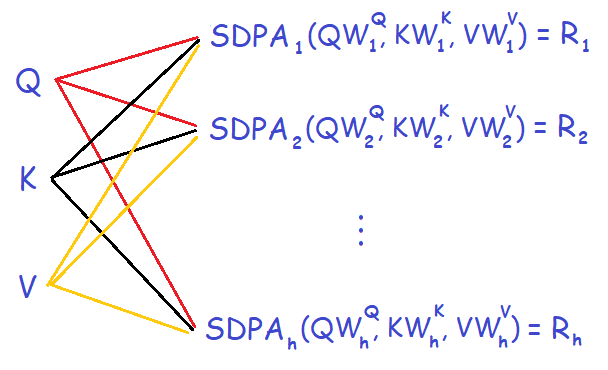

In [3]:
Image("images/MHA.png", width="50%")

К каждой голове с `SDPA` подаются те же самые $Q, K$ и $V$, но веса $W^Q, W^K$ и $W^V$ у каждого `SDPA` разные, так как каждая голова должна специализироваться на чем-то своем, а для этого должны быть разные веса. При обучении веса каждой головы подстроятся так, чтобы во время инференса модель могла одновременно фокусироваться на различных аспектах и типах взаимосвязей во входных данных.

На входе матрицы имеют следующие размерности:

- Матрица запросов $Q$: $\left(N_Q, d_{model}\right)$ $\newline$

- Матрица ключей $K$: $\left(N_K, d_{model}\right)$ $\newline$

- Матрица значений $V$: $\left(N_V, d_{model}\right)$

Обучаемые матрицы имеют следующие размерности:

- Матрица $W_i^Q$: $\left(d_{model}, \frac{d_{model}}{h}\right)$, $i∈[1, h]$ $\newline$

- Матрица $W_i^K$: $\left(d_{model}, \frac{d_{model}}{h}\right)$, $i∈[1, h]$ $\newline$

- Матрица $W_i^V$: $\left(d_{model}, \frac{d_{model}}{h}\right)$, $i∈[1, h]$ 

Выходные матрицы имеют размерность:

- Матрицы $R_i$: $\left(N_Q, \frac{d_{model}}{h}\right)$, $i∈[1, h]$ 

Таким образом, все размерности векторов в `Transformer` получаются стандартизированными благодаря параметру $d_{model}$, который позволяет легко изменять сложность и выразительную способность модели. Также стоит отметить, что при изменении числа голов $h$ количество параметров в механизме `Multi-Head Attention` остается неизменным. Это ключевое преимущество архитектуры, который позволяет экспериментировать с архитектурным выбором, игнорируя фактор изменения общей сложности модели.

Осталось только объединить результаты: умножить каждый результат на свою матрицу $W_i^O$ и полученные матрицы сложить.

$$
R=R_1 W_1^O + R_2 W_2^O + \,...\, R_h W_h^O
$$

где $W_i^O$ $-$ обучаемая матрица размерности $\left(\frac{d_{model}}{h}, d_{model}\right)$

Эту запись можно расписать в ином виде через конкатенацию матриц:

$$
R=\left(R_1 ⊕ R_2 ⊕ + \, ... \, ⊕ R_h\right) W^O
$$

где $W^O$ $-$ обучаемая матрица размерности $\left(d_{model}, d_{model}\right)$

Первый вариант более интуитивно понятный, второй вариант описывается в исходной статье про `Transformer`. 

Но оба варианта приводят к одному и тому же результату, если во втором случае все $R_i$ сконкатенировать по второй оси, то есть вдоль горизонтальной оси, а все $W_i^O$ сконкатенировать по первой оси, то есть вдоль вертикальной оси.

Произведение сконкатенированных матриц $R_i$ вдоль горизонтальной оси и сконкатенированных матриц $W_i^O$ вдоль вертикальной оси дает такой же результат, как и если бы мы отдельно перемножили эти матрицы между собой и поэлементно сложили бы.

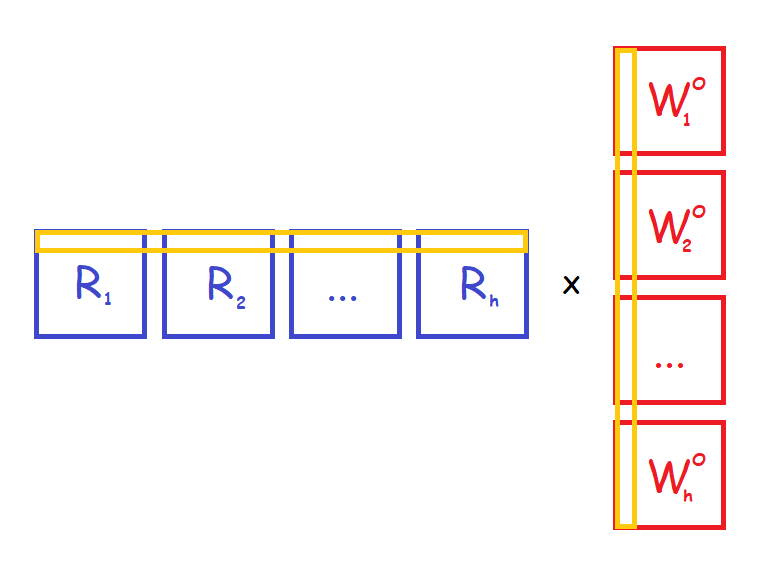

In [5]:
Image("images/w_o.png", width="50%")

Получаем формулу для `Multi-Head Attention`:

$W_i^Q ∈ \mathbb{R}^{d_{model} \,\times\, d_k} \quad W_i^K ∈ \mathbb{R}^{d_{model} \,\times\, d_k}$ 

$W_i^V ∈ \mathbb{R}^{d_{model} \,\times\, d_v} \quad W^O ∈ \mathbb{R}^{h d_v \,\times\, d_{model}}$

$d_k = d_v = \frac{d_{model}}{h}$

$Q_i = Q W_i^Q \quad K_i = K W_i^K \quad V_i = V W_i^V \quad i∈[1, h]$

$O_i = SDPA\left(Q_i, K_i, V_i\right) \quad i∈[1, h]$

$MHA\left(Q, K, V\right) = \left(O_1 ⊕ O_2 ⊕ + \, ... \, ⊕\, O_h\right) W^O$

---

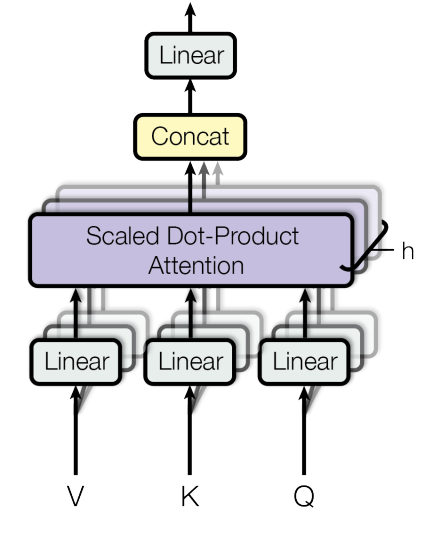

In [8]:
Image("images/mha_article.png", width="35%")

**Свойства `Multi-Head Attention`**

Возьмем одноканальное изображение. Это изображение делится на сетку из квадратных фрагментов фиксированного размера (например, $16 \times 16$ пикселей). Затем каждый такой квадрат можно вытянуть в вектор из $16 \times 16 = 256$ элементов. Каждый такой вектор проходит через полносвязный слой, после которого получаются векторы размерности $d_{model}$. Все эти векторы можно сложить в один тензор размерности $[\text{img_width}, \text{img_height}, d_{model}] = [N, M, r]$.

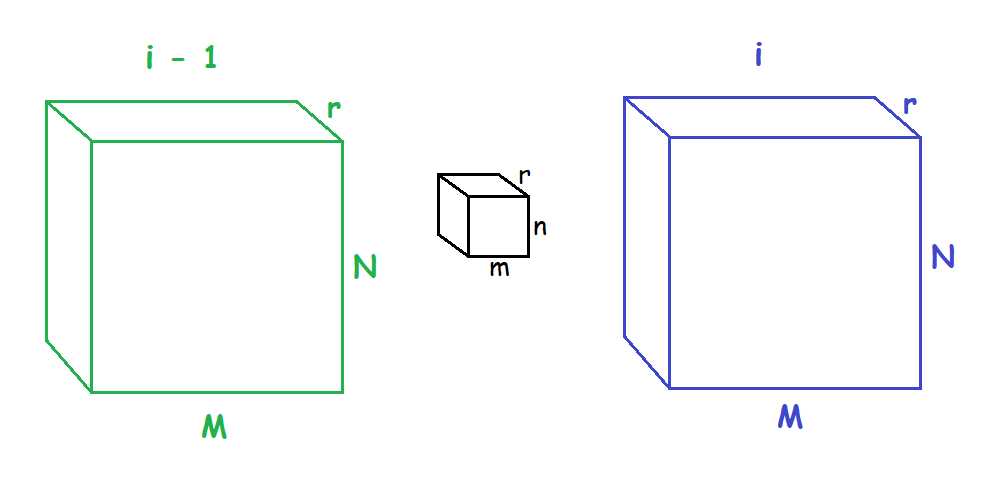

In [2]:
Image("images/mha_properties.png")

Из тензора $i-1$ слоя размерности $[N, M, r]$ получается тензор $i$ слоя тоже размерности $[N, M, r]$. Сверточный фильтр (черный на изображений) имеет размерность $[n, m, r]$.

| | conv | fc | mha |
| :---: | :---: | :---: | :---: | 
| `receptive field` | `m × n` | `M × N` | `M × N` |
| `# params` | `m ⋅ n ⋅ r²` | `(M ⋅ N ⋅ r)²` | `4 ⋅ r²` |

**Сравнение:**

1. `receptive field` у сверточного фильтра **( conv )** равен размеру этого фильтра, т. е. `m × n`. 

    `receptive field` у полносвязного слоя **( fc )** равен `M × N`, так как он видит каждый элемент с предыдущего тензора. 
    
    `receptive field` у `Multi-Head Attention` **( mha )** равен `M × N`, так как каждый вектор запроса с тензора $i-1$ слоя сравнивается с каждым вектором ключа. $\newline$

2. Количество параметров `# params` у сверточного слоя равен произведению количества параметров одного сверточного фильтра `m ⋅ n ⋅ r` на число этих фильтров `r` (число выходных карт признаков). 

    Количество параметров у полносвязного слоя равен произведению числа параметров во входном тензоре `M ⋅ N ⋅ r` на число параметров во выходном тензоре `M ⋅ N ⋅ r`. Это равносильно тому, что мы тензор $i-1$ слоя вытягиваем в длинный вектор, умножаем этот вектор на матрицу размерности `[M ⋅ N ⋅ r, M ⋅ N ⋅ r]`, полученный вектор приводим к нужной размерности $i$ слоя.
    
    Так как $d_{model}$ = `r`, так как вдоль 3 размерности тензоров расположены векторы. Число параметров каждой матрицы $W_i^Q, W_i^K, W_i^V$: $d_{model} \,\cdot\, \frac{d_{model}}{h} = r \,\cdot\, \frac{r}{h} = \frac{r^{\,2}}{h}$. Всего каждой матрицы $h$ штук. Число параметров каждой матрицы $W^O$: $d_{model} \,\cdot\, d_{model} = r^{\,2}$. В сумме получаем число параметров для `Multi-Head Attention`: $3 \cdot h \cdot \frac{r^{\,2}}{h} + r^{\,2} = 4r^{\,2}$. 
    
Таким образом, `Multi-Head Attention` имеет полный `receptive field`, но для достижения этого использует куда меньше параметров, чем полносвязные и сверточные слои.

---

**Как изменится выход `Multi-Head Attention`, если и к ключам, и к значениям применить одинаковую перестановку?**

$$
\begin{array}{|c|c|c|}
\hline
q & k & v \\
\hline
q_1 & k_1 & v_1 \\
q_2 & k_2 & v_2 \\
... & ... & ... \\
q_r & k_n & v_n \\
\hline
\end{array} ⟹ \begin{array}{|c|c|c|}
\hline
q & k & v \\
\hline
q_1 & k_2 & v_2 \\
q_2 & k_1 & v_1 \\
... & ... & ... \\
q_r & k_n & v_n \\
\hline
\end{array}
$$

Важно, чтобы ключи и значения менялись одинаковым образом так.

$P$ $-$ определенная перестановка элементов.

$$MHA\left(Q, P\left(K\right), P\left(V\right)\right) = MHA\left(Q, K, V\right)$$

Если и к ключам, и к значениям применить одинаковую перестановку, то выход `Multi-Head Attention` никак не изменится. Это связано с тем, что внутри каждого блока `SDPA` для каждого запроса происходит взвешенная сумма векторов значений. То в каком порядке будет идти суммирование векторов значений не имеет значения, важно лишь то, чтобы вес для каждого вектора значения оставался тем же самым.

**Как изменится выход `Multi-Head Attention`, если к запросам применить перестановку?**

$$
\begin{array}{|c|c|c|}
\hline
q & k & v \\
\hline
q_1 & k_1 & v_1 \\
q_2 & k_2 & v_2 \\
... & ... & ... \\
q_r & k_n & v_n \\
\hline
\end{array} ⟹ \begin{array}{|c|c|c|}
\hline
q & k & v \\
\hline
q_2 & k_1 & v_1 \\
q_1 & k_2 & v_2 \\
... & ... & ... \\
q_r & k_n & v_n \\
\hline
\end{array}
$$

$P$ $-$ определенная перестановка элементов.

$$MHA\left(P\left(Q\right), K, V\right) = P\left(MHA\left(Q, K, V\right)\right)$$

Если к запросам применить перестановку $P$, то выход `Multi-Head Attention` изменится так, что это будет эквивалентно тому, что выходу `Multi-Head Attention` без перестановки запросов применится перестановка $P$. Это можно представить так, что результаты для каждого запроса будут теми же самыми, но записаны в другом порядке (в порядке, которая определяется перестановкой $P$). 

---

**Про расход памяти в `Multi-Head Attention`**.

`Multi-Head Attention` имеет квадратичный расход памяти и это является главным недостатком Трансформеров при работе с длинными последовательностями.

$$
Q \in \mathbb{R}^{L \,\times\, d} \quad K \in \mathbb{R}^{L \,\times\, d}
$$

Внутри `SDPA` происходит перемножение $Q$ и $K^T$. Из-за того, что нужно хранить сходство каждого вектора запроса с каждым вектором ключа, в памяти нужно хранить матрицу: $(L \times d) \cdot (d \times L) \rightarrow (L \times L)$.

Получаем:

- Количество элементов в матрице: $L^2$. $\newline$

- Расход памяти: $O(L^2)$.

При увеличении длины последовательности $L$ в 2 раза, потребление памяти возрастает в 4 раза. Это нужно учитывать.

---

**Layer Normalization**

В `Transformer` отказались от **Batch Normalization** в пользу **Layer Normalization**.

Пусть у нас есть входной вектор $\overline{a}$ размерности $N = d_{model}$ (например, представление одного слова или токена).

**Шаг 1: Вычисляем среднее $\mu$ и стандартное отклонение $\sigma$ для этого вектора.**

$$
\mu = \frac{1}{N} \sum_{i=1}^N \overline{a}_i
$$

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N \left(\overline{a}_i - \mu\right)^2}
$$

**Шаг 2: Нормализация и аффинное преобразование.**

$$
LN\left(\overline{a}\right) = \frac{\overline{g}}{\sigma} \odot \left(\overline{a} - \mu\right) + \overline{b}
$$

Где:
- $\frac{\overline{a} \,-\, \mu}{\sigma}$ $-$ операция стандартизации (делает среднее значение 0, дисперсию 1 для вектора $\overline{a}$). $\newline$

- $\overline{g}$ $-$ обучаемый вектор той же размерности, что и у $\overline{a}$. Позволяет модели иметь нужную ей дисперсию или отменить нормализацию. $\newline$

- $\overline{b}$ $-$ обучаемый вектор той же размерности, что и у $\overline{a}$. Позволяет модели иметь нужное ей среднее значение или отменить нормализацию.$\newline$

- $\odot$ $-$ поэлементное умножение.

Важно уточнить, что для векторов $\overline{g}$ и $\overline{b}$ происходят поэлементные операции. Это значит, что каждая компонента вектора масштабируется и смещается независимо от других. Если после стандартизации все компоненты вектора имели одинаковый масштаб, то $\overline{g}$ и $\overline{b}$ позволяют модели придать разным компонентам разный масштаб и смещение.

**LayerNorm** берет **один** конкретный пример (один вектор одного слова) и нормализует его, используя статистику **только этого самого примера**.

- Он не смотрит на соседние примеры в батче. $\newline$

- Он не смотрит на другие слова в предложении (каждый токен нормализуется независимо). $\newline$

- Вектора $\overline{g}$ и $\overline{b}$ одни и те же для разных векторов (токенов).

**Отличие LayerNorm от BatchNorm. И почему BatchNorm не подходит для Трансформера?**

BatchNorm считает статистики вдоль оси батча для каждого признака отдельно.

**Проблемы BatchNorm:**

- **Зависимость от размера батча.** BatchNorm хорошо работает только при больших батчах. В трансформерах (особенно больших) батчи часто маленькие из-за огромного потребления памяти, что делает статистику BatchNorm шумной и нестабильной. $\newline$

- **Переменная длина последовательностей.** 

    Предложения могут иметь разную длину. Чтобы собрать их в батч, используется **Padding** (дополнение нулями). Если использовать BatchNorm, то эти нули будут участвовать в расчете среднего и дисперсии, сильно искажая статистику для реальных слов.

    Статистики для 5-го слова в предложении будут считаться по 5-ым словам всех предложений в батче. Но в одном предложении 5-е слово $-$ это конец мысли, а в другом $-$ только начало. У них разная семантическая природа, усреднять их странно.
    
**Преимущества LayerNorm:**

LayerNorm считает статистику вдоль оси признаков $d_{model}$ для каждого токена отдельно.

- **Независимость от батча.** Неважно, сколько примеров в батче, результат для конкретного слова будет одинаковым. $\newline$

- **Устойчивость к длине.** Неважно, какой длины предложение и сколько там паддингов. LayerNorm обрабатывает каждый токен индивидуально. $\newline$

- **Одинаковая работа во время обучения и инференса.** Формула одна и та же и для обучения, и для предсказания. Не нужно накапливать и хранить скользящие средние для среднего значения и дисперсии.

---

### Transformer Encoder

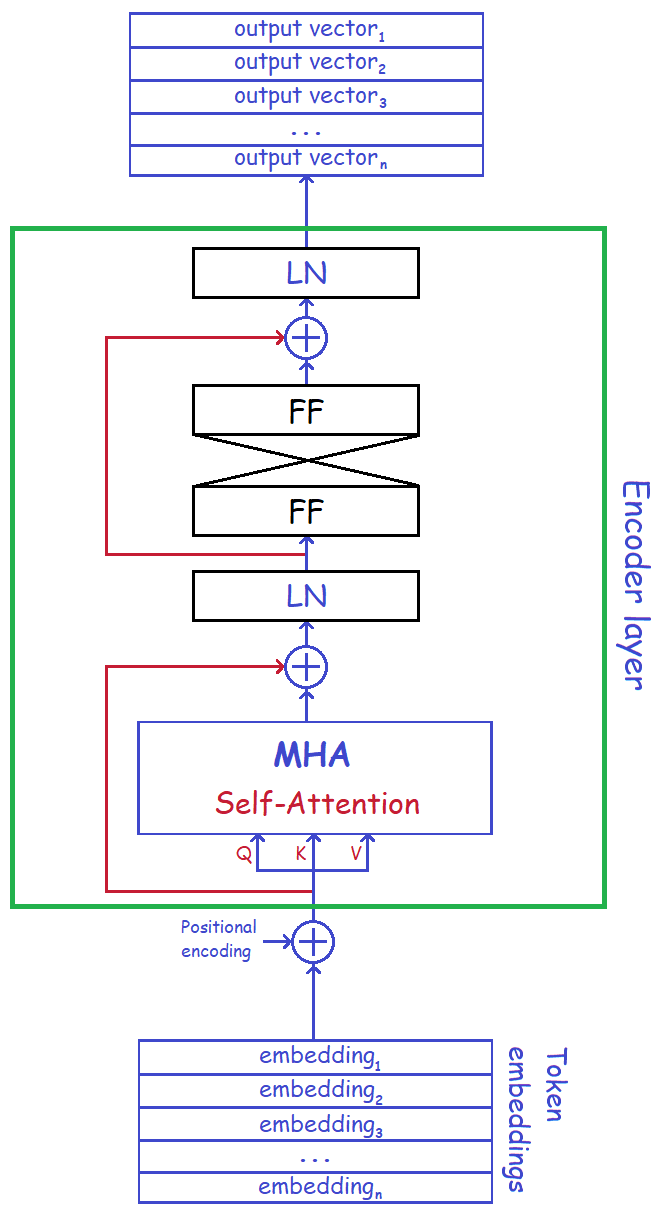

In [3]:
Image("images/Transformer_encoder.png", width="50%")

**Принцип формирования входной матрицы в `Encoder`:**

1. Формируется входная матрица, строки которой являются эмбеддингами (векторами) токенов. $\newline$

2. К каждому вектору из входной матрицы прибавляется вектор из `Positional encoding`, чтобы `Encoder` понимал порядок входных токенов.

**Принцип работы одного `Encoder` слоя:**

1. На вход `Encoder` слоя поступает входная матрица. Если это первый слой, то входная матрица $-$ матрица эмбеддингов. Если это любой другой слой после первого, то входная матрица $-$ матрица, которая является выходом предыдущего слоя. Размерность входной матрицы в обоих случаях: $[N, d_{model}]$. $N$ $-$ длина последовательности, $d_{model}$ $-$ гиперпараметр Трансформера. $\newline$

2. Входная матрица проходит через блок `Self-Multi-Head Attention`, причем эта матрица будет являться и матрицей запросов $Q$, и матрицей ключей $K$, и матрицей значений $V$. Выход с блока `Self-Multi-Head Attention` складывается со входной матрицей `(Skip Connection)`. На выходе матрица размерности $[N, d_{model}]$. $\newline$

3. Полученная матрица проходит через `Layer Normalization (LN)` слой. Стоит напомнить, что каждый вектор в таком слое обрабатывается независимо, используя статистики только самого вектора. На выходе матрица размерности $[N, d_{model}]$. $\newline$

4. Матрица $X$ после `Layer Normalization` проходит через 2 полносвязных слоя. Для этих 2 слоев формула такая: 

    $$2FF \left(X\right) = ReLU \left(X \, W_1  + b_1 \right) W_2 + b_2$$
    
    $W_1 \in \mathbb{R}^{d_{model} \,\times\, 4 d_{model}},$ $\quad$ $W_2 \in \mathbb{R}^{4 d_{model} \,\times\, d_{model}}$ $-$ обучаемые матрицы весов.
    
    $b_1 \in \mathbb{R}^{4 d_{model}},$ $\quad$ $b_2 \in \mathbb{R}^{d_{model}}$ $-$ обучаемые векторы смещении, которые применяются к каждой строке матрицы.
    
    Получается, размерности векторов сначала увеличиваются в 4 раза, затем снова понижаются до исходной размерности.
    
    Выходная матрица с полносвязных слоев $2FF \left(X\right)$ складывается с входной матрицей $X$ `(Skip Connection)`. 
    
    На выходе матрица размерности $[N, d_{model}]$. $\newline$
    
5. Полученная матрица проходит через `Layer Normalization (LN)` слой. На выходе матрица размерности $[N, d_{model}]$.

Получается, на входе в `Encoder` слой матрица размерности $[N, d_{model}]$, на выходе тоже матрица размерности $[N, d_{model}]$. В оригинальном энкодере Трансформера было 6 последовательно идущих `Encoder` слоев.

**В чем смысл Self-Attention, если $Q, K, V$ получаются из одной входной матрицы?**

Хоть источник один ($X$), обучаемые матрицы $W^Q, W^K, W^V$ проецируют его в три разных подпространства с разными целями:

- **Query ($Q$):** Отвечает за то, **какую информацию** токен хочет найти у соседей, чтобы уточнить свой смысл. $\newline$

- **Key ($K$):** Служит для вычисления релевантности при взаимодействии с $Q$. Это "адрес", по которому происходит поиск. $\newline$

- **Value ($V$):** Это **смысловое содержание** токена. Именно из векторов внутри матрицы $V$, которые отвечают за соседние токены, собирается та информация, которую **получит** текущий токен для своего обновления.

Как это происходит:

- **На входе:** Векторы независимы (как слова в словаре). $\newline$

- **Механизм:** Self-Attention вычисляет взаимосвязи между всеми элементами одной и той же последовательности. $\newline$

- **На выходе:** Вектор каждого токена становится взвешенной суммой векторов значений всех токенов.

**Итог:**
Смысл Self-Attention $-$ обновить вектор токена, подмешав в него информацию от других токенов этой же последовательности. Это превращает `"изолированный токен"` в `"токен с учетом контекста"`.

---

### Positional encoding

В силу свойств `Multi-Head Attention`, которые были рассмотрены выше, `Transformer` ничего не знает про порядок входных векторов, хотя это важно для понимания смысла предложения. По этой причине был предложен `Positional encoding`. Суть метода в том, что каждому входному вектору прибавляется вектор, который зависит от позиции этого вектора в последовательности.

Формулы:

$$
PE_{\,pos}^{\,(\,2i\,)} = \sin\left( \frac{pos}{10000^{\,2i\, / \,d_{model}}} \right)
$$

$$
PE_{\,pos}^{\,(\,2i+1\,)} = \cos\left( \frac{pos}{10000^{\,2i\, / \,d_{model}}} \right)
$$

То есть при четном $i$ индексе вектора используется формула с $\sin$, при нечетном $i$ $-$ формула с $\cos$. 

$pos$ $-$ позиция (номер) токена в последовательности.

Пример работы алгоритма `Positional encoding`:

Пусть $d_{model}=512$.

$$PE_{\,1} = \left(\sin{1}, \cos{1}, \sin{\frac{1}{10000^{\,1\, / \,256}}}, \cos{\frac{1}{10000^{\,1\, / \,256}}}, \, ... \, , \sin{\frac{1}{10000}}, \cos{\frac{1}{10000}} \right)$$

$$PE_{\,2} = \left(\sin{2}, \cos{2}, \sin{\frac{2}{10000^{\,1\, / \,256}}}, \cos{\frac{2}{10000^{\,1\, / \,256}}}, \, ... \, , \sin{\frac{2}{10000}}, \cos{\frac{2}{10000}} \right)$$

Получается, в начале вектора $PE_{\,i}$ изменение значений происходит гораздо быстрее, чем в конце.

- Если представить токены, которые находятся близко друг к другу, то между `Positional encoding` векторами будет сильное расхождение в начале векторов, но слабое расхождение в конце. Например, разница между $\sin{1}≈0.84$ и $\sin{2}≈0.91$ сильно больше, чем разница между $\sin{\frac{1}{10000}}≈0.0001$ и $\sin{\frac{2}{10000}}≈0.0002$. $\newline$

- Если интересующие нас токены находятся достаточно далеко, то между `Positional encoding` векторами будет сильное расхождение где-то в центре, слабое расхождение в конце, а в начале может быть как сильное, так и слабое расхождение, так как $\sin$ и $\cos$ периодические функции. $\newline$

- Если же токены находятся оочень далеко в каком-нибудь длинном тексте, то можно ожидать, что между `Positional encoding` векторами будет сильное расхождение в конце векторов, а в начале и середине нет никаких гарантий на степень расхождении, так как там аргументы функции больше чем период этих функции.

**Почему именно такой способ?**

Трансформер смотрит на все слова одновременно. Для него фраза «Мама мыла раму» и «Раму мыла мама» $-$ это одно и то же облако векторов, если не добавить информацию о позиции.

**Варианты, которые не работают:**

- **Просто нумеровать (1, 2, 3...):** Числа будут расти бесконечно. Для длинных текстов значения станут огромными, что сломает обучение нейросети (градиенты взорвутся). $\newline$

- **Нормировать (0...1):** Если у нас предложение из 5 слов, шаг будет 0.2. Если из 100 слов $-$ шаг 0.01. Сеть не сможет выучить универсальное правило «соседнего слова», потому что расстояние между соседями всегда разное.

Нам же нужен метод, который:

- Дает уникальный код для каждой позиции. $\newline$

- Значения ограничены (не улетают в бесконечность). $\newline$

- Расстояние между позициями одинаковое, независимо от длины текста.

Представим, как мы считаем в двоичной системе:

| Позиция | Бит 3 | Бит 2 | Бит 1 | Бит 0 |
| :---: | :---: | :---: | :---: | :---: |
| **0** | 0 | 0 | 0 | 0 |
| **1** | 0 | 0 | 0 | 1 |
| **2** | 0 | 0 | 1 | 0 |
| **3** | 0 | 0 | 1 | 1 |
| **4** | 0 | 1 | 0 | 0 |
| **5** | 0 | 1 | 0 | 1 |

Заметим закономерность:

- **Бит 0** меняется очень быстро (`0-1-0-1...` частота высокая). $\newline$

- **Бит 1** меняется медленнее (`0-0-1-1...` частота ниже). $\newline$

- **Бит 2** еще медленнее.

Авторы `Positional Encoding` взяли эту идею, но вместо дискретных нулей и единиц, использовали непрерывные функции $-$ синусы и косинусы. Таким образом, вектор $PE_{\,pos}$ $-$ это набор значений разных "часов", где одни стрелки бегут быстро, а другие еле ползут. Эта комбинация создает уникальный код для каждого момента времени $pos$.

**Зачем делитель $10000^{\,2i \,/\, d_{model}}$?**

В формуле делитель выглядит так: $10000^{\,2i \,/\, d_{model}}$. Это определяет **период** функции.

- Для первых координат вектора ($i=0$) делитель равен $10000^{\,0} = 1$. Период функции $2\pi \approx 6$ токенов. $\newline$

- Для последних координат ($i \approx \frac{d_{model}}{2}$) делитель равен $10000^{\,1} = 10000$. Период функции $10000 \cdot 2\pi \approx 62800$ токенов. 

Диапазон от $1$ до $10000$ выбран эмпирически. Он достаточно широк, чтобы для любой разумной длины текста (хоть 100 токенов, хоть 5000) получаемые `Positional Encoding` вектора оставались уникальными и не повторялись.

### Почему такой подход работает?

$$ Q = X W_Q, \quad K = X W_K $$

Где $X$ $-$ входная матрица размерности $[N \times d_{model}]$.

Пусть $X_i = E_i + P_i$ и $X_j = E_j + P_j$. $\quad$ $E$ $-$ эмбеддинг слова, $P$ $-$ позиционный вектор.

Вектор запроса: $q_i = (E_i + P_i) W_Q$

Вектор ключа: $k_j = (E_j + P_j) W_K$

Рассмотрим скалярное произведение в `Self Attention` между вектором запроса $q_i$ и вектором ключа $k_j$. В векторном виде это $q_i^{\vphantom{T}} k^T_j$:

$$ Score_{i, \, j} = \left( (E_i + P_i)W_Q \right) \left( (E_j + P_j)W_K \right)^T $$

Используем свойство транспонирования произведения $(AB)^T = B^T A^T$:

$$ \left( (E_j + P_j)W_K \right)^T = W_K^T (E_j + P_j)^T = W_K^T (E_j^T + P_j^T) $$

Подставляем и раскрываем скобки:

$$ Score_{i, \, j} = (E_i + P_i) \underbrace{W_Q W_K^T}_{M} (E_j^T + P_j^T) $$

Обозначим $M = W_Q W_K^T$. Это одна матрица размерности ($d_{model} \times d_{model}$).

Теперь раскрываем скобки полностью. Получаем 4 скаляра:

$$
Score_{i, \, j} = \underbrace{E_i M E_j^T}_{(1)} + \underbrace{E_i M P_j^T}_{(2)} + \underbrace{P_i M E_j^T}_{(3)} + \underbrace{P_i M P_j^T}_{(4)}
$$

**Слагаемое (1): $E_i M E_j^T$ (Content − Content)**

Здесь взаимодействуют только эмбеддинги слов. Обучаемая матрица $M$ учится находить семантическую связь.

- Например: Если $E_i$ $-$ "черный", а $E_j$ $-$ "квадрат", матрица $M$ сделает так, чтобы скалярное произведение было большим.

**Слагаемые (2) и (3): $E_i M P_j^T$ и $P_i M E_j^T$ (Content − Position)**

Указывает, насколько токен (с эмбеддингом $E_i$ или $E_j$) ожидает увидеть что-то на абсолютной позиции $P_i$ или $P_j$.

Эти слагаемые имеют очень специфичные роли, так как привязаны к конкретным абсолютным позициям и скорее даже вредят, внося лишний шум в общую сумму слагаемых. По этой причине в дальнейшем придумывались более мощные подходы, которые **не привязываются к конкретным позициям**.

Например, в коде на Python import часто стоит в начале. Сеть может выучить глобальный паттерн: "Если я вижу название библиотеки, мне полезно глянуть на позиции 0-5".

**Слагаемое (4): $P_i M P_j^T$ (Position − Position)**

Рассмотрим скалярное произведение между позиционными векторами.

Вектор $PE$ состоит из множества пар $(PE_{\,pos}^{\,(\,2i\,)}, PE_{\,pos}^{\,(\,2i+1\,)})$. Весь вектор $-$ это просто конкатенация (склейка) этих пар.

$$ PE = [\text{пара}_{\,0}, \text{пара}_{\,1}, \dots, \text{пара}_{\,255}] $$

Пусть $d_{model}=512$, тогда у нас 256 таких блоков.

Посмотрим, чему равно скалярное произведение двух векторов позиций $PE_{\,t}$ и $PE_{\,t+k}$:

$$ PE_{\,t} \cdot PE_{\,t+k} = \sum_{j=0}^{d_{model} - 1} PE_{\,t}^{\,j} \cdot PE_{\,t+k}^{\,j} $$

Так как вектор состоит из пар синусов и косинусов, эта сумма распадается на сумму по блокам. Для каждого блока $i$ мы имеем свойство косинуса разности:

$$ \sin \left(\omega_i t\right) \cdot \sin \left(\omega_i(t+k) \right) + \cos \left(\omega_i t \right) \cdot \cos \left(\omega_i(t+k) \right) = \cos(\omega_i( (t+k) - t )) = \cos(\omega_i k) $$

$$\omega_i = \frac{1}{10000^{\,2i\, / \,d_{model}}}$$

**Итог для всего вектора:**

$$ PE_{\,t} \cdot PE_{\,t+k} = \sum_{i=0}^{255} \cos\left(\omega_i \cdot k\right) $$

**Что это значит?**

Результат скалярного произведения позиционных векторов **зависит только от относительного расстояния $k$** между позициями и вообще не зависит от абсолютных позиции $t$.

**Посмотрим, где у скалярного произведения позиционных векторов получается максимум.**

$$ PE_{\,t} \cdot PE_{\,t+k} = \sum_{i=0}^{255} \cos\left(\omega_i \cdot k\right) $$

- Когда $k = 0$, все косинусы равны $\cos(0) = 1$. Сумма максимальна. $\newline$

- Когда $k \neq 0$, не все косинусы достигают своего максимального значения.

Получается, максимум достигается тогда, когда **позиционные векторы совпадают.**

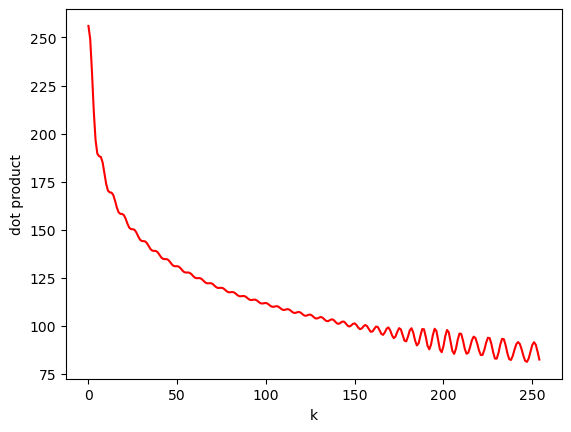

In [4]:
d_model = 512
res = []
for k in range(255):
    r = sum([np.cos(1 / 10000**(2*i / d_model) * k) for i in range(0, 256)])
    res.append(r)


plt.plot(range(255), res, color="red")
plt.xlabel("k")
plt.ylabel("dot product");

Мы рассмотрели скалярное произведение позиционных векторов, но в $P_i M P_j^T$ есть еще матрица $M$. 

Если $M$ $-$ единичная матрица, то это чистое скалярное произведение, и мы получаем ситуацию, которая описана выше, и зависимость только от относительного расстояния между позициями.

Нейросети достаточно выучить $M$ так, чтобы она не разрушала это свойство или усиливала его, и тогда **слагаемое (4)** будет отвечать за связь между токенами, которые стоят на определенном расстоянии **относительно** друг друга.

Пример того, как должна выглядеть матрица $M$ в идеальном случае:

Пусть $d = d_{model}$. 

Вектор позиции:

$$PE_{pos} = \begin{bmatrix} \sin(\omega_0 pos) & \cos(\omega_0 pos) & \sin(\omega_1 pos) & \cos(\omega_1 pos) & \dots & \cos(\omega_{\frac{d}{2}-1} pos) \end{bmatrix}$$

Для того, чтобы 4 слагаемое могло вычислять относительную позицию, обучаемая матрица $M = W_Q W_K^T$ должна уметь связывать все частоты сразу. Математически «идеальная» матрица $M$, которая настраивается на поиск соседа на расстоянии $k$, будет блочно-диагональной:

$$M = \begin{pmatrix}
\color{blue}{R_0} & 0 & \dots & 0 \\
0 & \color{blue}{R_1} & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & \color{blue}{R_{\frac{d}{2}-1}}
\end{pmatrix}
, \quad \text{где } R_i = \begin{pmatrix} \cos(\omega_i k) & \sin(\omega_i k) \\ -\sin(\omega_i k) & \cos(\omega_i k) \end{pmatrix}$$

Умножение вектора на блочно-диагональную матрицу эквивалентно независимому умножению каждой пары компонент на свой блок $R_i$.

$$PE_{pos} \cdot M = \begin{bmatrix} (\sin(\omega_0 pos), \cos(\omega_0 pos)) \cdot R_0 & (\sin(\omega_1 pos), \cos(\omega_1 pos)) \cdot R_1 & \dots \end{bmatrix}$$

В итоге при умножении $PE_{pos}$ на матрицу $M$ получаем:

$$
PE_{pos} \cdot M = PE_{pos-k}
$$

То есть, подбирая матрицу $M$, Трансформер способен смотреть на токены, которые расположены на некотором расстоянии относительно нужного токена.

Мы получили, что слагаемых, которые влияют на веса внимания, всего 4, а **обучаемая матрица всего одна для каждого слагаемого**. Из этого напрашивается вывод, что одна матрица $M = W_Q W_K^T$ не может идеально и независимо оптимизировать все 4 слагаемых одновременно. Как же тогда быть?

- **Multi-Head Attention.** В Трансформере матрица весов $Q K^T$ считается не один раз, а $h$ раз, то есть для каждой головы. У каждой головы свои собственные матрицы $W_Q$ и $W_K$. Соответственно, у каждой головы своя уникальная матрица $M_{head\_1}, M_{head\_2}, \dots, M_{head\_h}$. Поэтому каждая голова может настраивать обучаемые матрицы так, чтобы максимизировать конкретное слагаемое в зависимости от задачи. В итоге получаем, что каждая матрица $R_i$ с каждой головы конкатенируется в одну матрицу, которая затем умножается на обучаемую матрицу $W_O$. На выходе получаем матрицу, в каждой строке (строки соответствуют токенам) которого есть как смысловая информация, так и позиционная. $\newline$

- **Например:** $\newline$

    - Голова 1 (Позиционная): Смотрит на предыдущее слово "не" и выдает вектор $v_1$, который говорит: "Активируй признак Отрицания!". $\newline$

    - Голова 2 (Смысловая): Смотрит на текущее слово "счастлив" и выдает вектор $v_2$, который говорит: "Активируй признак Эмоции Счастья!". $\newline$
    
    - Вектор на выходе Attention слоя содержит информацию: "Это Счастье + Это Отрицание". В дальнейшем другими слоями (Feed-Forward) этот вектор по смыслу может интерпретироваться как "Грусть".

### Transformer Decoder

**В каких случаях достаточен только Encoder `(BERT, ViT)`:**

- Когда нам нужно получить некий результат на основе всего входа. Например, классификация с помощью `[CLS]` токена. $\newline$

- Структура выхода привязана к структуре входа. Например, классификация каждого токена.

**В каких случаях достаточен только Decoder `(GPT)`:**

- Структура выхода не привязана к структуре входа. $\newline$

- Распределение входных данных близко к распределению выходных данных. Например, при продолжении текста на одном и том же языке.

**В каких случаях нужен и Encoder, и Decoder:**

- Структура выхода не привязана к структуре входа. $\newline$

- Распределение входных данных отличается от распределения выходных данных. Например, при машинном переводе с одного языка на другой.

**Примечание:** `LLM` легко могут переводить с одного языка на другой, хотя архитектурно это только **Decoder**. Но дело в том, что в них столько параметров, что они могут себе это позволить.


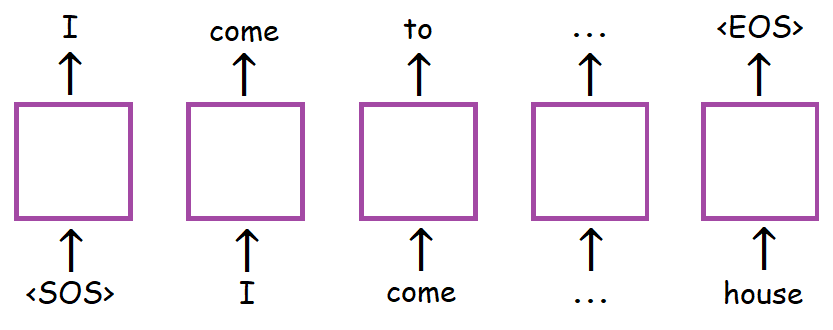

In [39]:
Image("images/Decoder.png", width="80%")

### Masked Multi-Head Attention

Если в Декодере использовать обычный `Multi-Head Attention`, который используется в Энкодере, то возникает проблема подглядывания на следующие токены в последовательности. При таком подходе для нейросети задача кажется тривиальной, так как все следующие токены последовательности она уже видела и знает. По этой причине придумали `Masked Multi-Head Attention`.

Рассмотрим формулу для `SDPA`:

$$
Softmax\left(\frac{Q K^T}{\sqrt{d}}\right) = Softmax\begin{pmatrix}
\frac{\vec{q}_1^T \vec{k}_1}{\sqrt{d}} & \frac{\vec{q}_1^T \vec{k}_2}{\sqrt{d}} & \frac{\vec{q}_1^T \vec{k}_3}{\sqrt{d}} & ... \\
\frac{\vec{q}_2^T \vec{k}_1}{\sqrt{d}} & \frac{\vec{q}_2^T \vec{k}_2}{\sqrt{d}} & \frac{\vec{q}_2^T \vec{k}_3}{\sqrt{d}} & ... \\
\frac{\vec{q}_3^T \vec{k}_1}{\sqrt{d}} & \frac{\vec{q}_3^T \vec{k}_2}{\sqrt{d}} & \frac{\vec{q}_3^T \vec{k}_3}{\sqrt{d}} & ... \\
... & ... & ... & ...
\end{pmatrix}=\begin{pmatrix}
δ_1(\vec{q}_1) & δ_2(\vec{q}_1) & δ_3(\vec{q}_1) & ... \\
δ_1(\vec{q}_2) & δ_2(\vec{q}_2) & δ_3(\vec{q}_2) & ... \\
δ_1(\vec{q}_3) & δ_2(\vec{q}_3) & δ_3(\vec{q}_3) & ... \\
... & ... & ... & ...
\end{pmatrix}
$$

**Чего мы хотим добиться?**

Мы хотим, чтобы на первом шаге для Декодера все выглядело так, будто дальше ничего нет, кроме `<SOS>` токена (Start Of Sequence). На втором шаге мы хотим, чтобы Декодер видел только `<SOS>` токен и первый токен последовательности. На третьем шаге нас устраивает, что Декодер видит только `<SOS>` токен и первые 2 токена последовательности. И так далее.

Веса для наших входных токенов на выходе из $Softmax\left(\frac{Q K^T}{\sqrt{d}}\right)$ представлены по строчкам. То есть веса для `<SOS>` токена расположены вдоль первой строчки, веса для первого токена последовательности $-$ вдоль второй строчки и так далее.

Получается, мы хотим на выходе из $Softmax\left(\frac{Q K^T}{\sqrt{d}}\right)$ видеть такую картину:

$$
\begin{pmatrix}
δ_1(\vec{q}_1) & 0 & 0 & ... \\
δ_1(\vec{q}_2) & δ_2(\vec{q}_2) & 0 & ... \\
δ_1(\vec{q}_3) & δ_2(\vec{q}_3) & δ_3(\vec{q}_3) & ... \\
... & ... & ... & ...
\end{pmatrix}
$$

То есть все веса выше главной диагонали равны 0. Мы получаем, что **вектора значений не будут учитываться у тех токенов, у которых веса равны 0**. Из формулы $SDPA\left(\vec{q}, k, v\right) = \sum_{i=1}^n δ_i \cdot \vec{v}_i$ следует, что первый токен смотрит только на самого себя, второй токен смотрит на самого себя и предыдущий токен, третий токен смотрит на себя и два предыдущих токена и так далее. Самое главное, что мы не подсматриваем на следующие токены последовательности.

**Как достичь такого результата?**

Просто обнулять веса на выходе из $Softmax\left(\frac{Q K^T}{\sqrt{d}}\right)$ нельзя, так как в таком случае сумма весов на каждой строке выходной матрицы не будет равняться 1. Может быть даже такая ситуация, что какой-то из весов, который мы обнулили, был близок к 1, тогда сумма весов будет близка к 0. То есть при таком подходе другие токены косвенно все же будут влиять на результат, чего мы хотим исключить.

Одним из способов, как достичь того, чего мы хотим $-$ это ставить $(- \infty)$ на те позиции, где мы хотим видеть 0 после применения $Softmax$.

$$
Softmax\begin{pmatrix}
\frac{\vec{q}_1^T \vec{k}_1}{\sqrt{d}} & - \infty & - \infty & ... \\
\frac{\vec{q}_2^T \vec{k}_1}{\sqrt{d}} & \frac{\vec{q}_2^T \vec{k}_2}{\sqrt{d}} & - \infty & ... \\
\frac{\vec{q}_3^T \vec{k}_1}{\sqrt{d}} & \frac{\vec{q}_3^T \vec{k}_2}{\sqrt{d}} & \frac{\vec{q}_3^T \vec{k}_3}{\sqrt{d}} & ... \\
... & ... & ... & ...
\end{pmatrix}=\begin{pmatrix}
δ_1(\vec{q}_1) & 0 & 0 & ... \\
δ_1(\vec{q}_2) & δ_2(\vec{q}_2) & 0 & ... \\
δ_1(\vec{q}_3) & δ_2(\vec{q}_3) & δ_3(\vec{q}_3) & ... \\
... & ... & ... & ...
\end{pmatrix}
$$

Стоит отметить, что через добавление $(- \infty)$ в матрицу внимания можно менять `Receptive Field ` Трансформера.

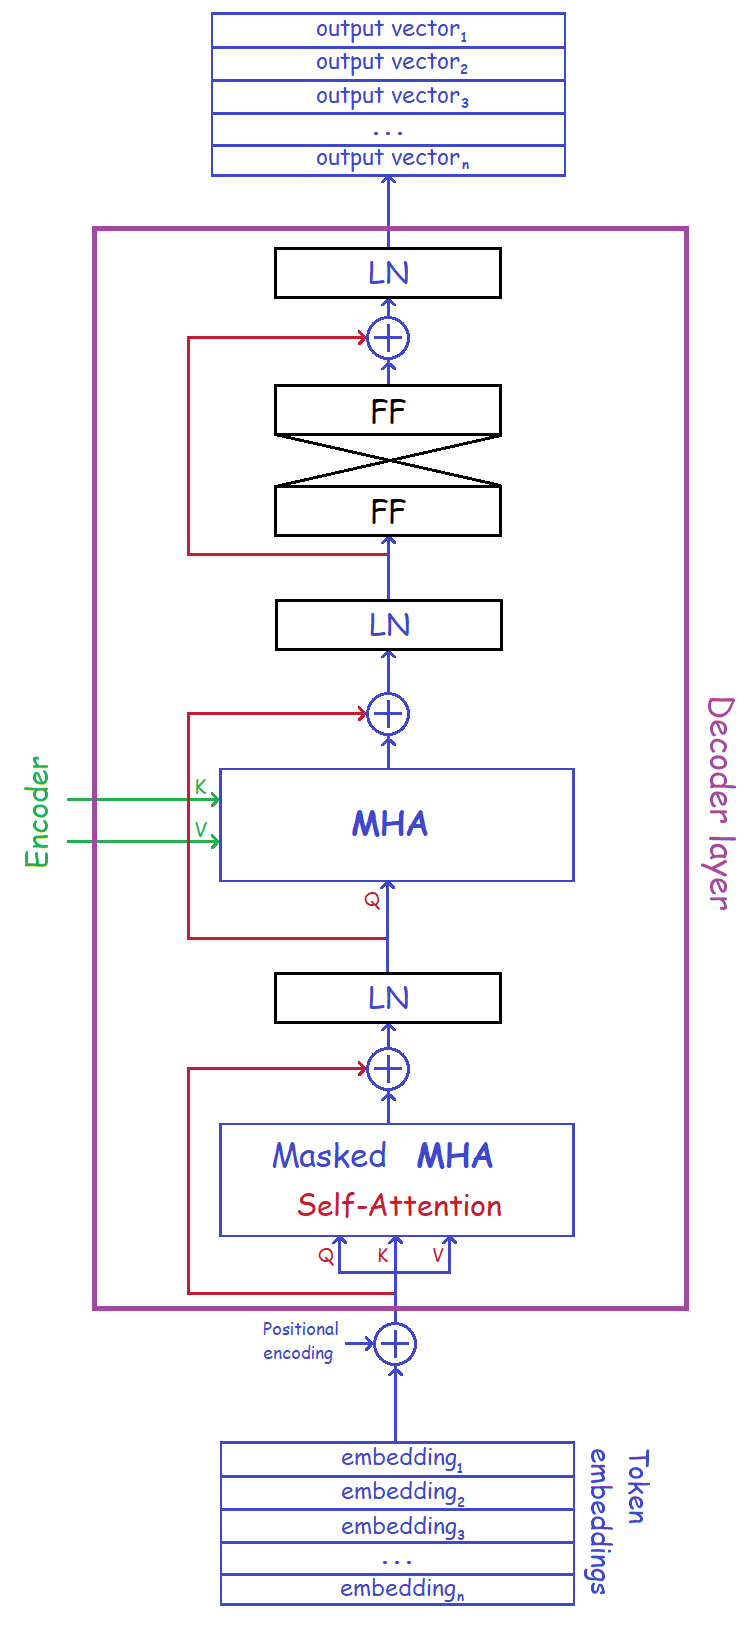

In [34]:
Image("images/Transformer_decoder.png", width="50%")

**Принцип формирования входной матрицы в `Decoder`:**

1. Формируется входная матрица, строки которой являются эмбеддингами (векторами) токенов. $\newline$

2. К каждому вектору из входной матрицы прибавляется вектор из `Positional encoding`, чтобы `Decoder` понимал порядок входных токенов.

**Принцип работы одного `Decoder` слоя:**

1. На вход `Decoder` слоя поступает входная матрица. Если это первый слой, то входная матрица $-$ матрица эмбеддингов. Если это любой другой слой после первого, то входная матрица $-$ матрица, которая является выходом предыдущего слоя. Размерность входной матрицы в обоих случаях: $[N, d_{model}]$. $N$ $-$ длина последовательности, $d_{model}$ $-$ гиперпараметр Трансформера. $\newline$

2. Входная матрица проходит через блок `Masked Self-Multi-Head Attention`, причем эта матрица будет являться и матрицей запросов $Q$, и матрицей ключей $K$, и матрицей значений $V$. Выход с блока `Masked Self-Multi-Head Attention` складывается со входной матрицей `(Skip Connection)`. На выходе матрица размерности $[N, d_{model}]$. $\newline$

3. Полученная матрица проходит через `Layer Normalization (LN)` слой. Стоит напомнить, что каждый вектор в таком слое обрабатывается независимо, используя статистики только самого вектора. На выходе матрица размерности $[N, d_{model}]$. $\newline$

4. Дальше идет `Multi-Head Attention` слой. Это не `Self Attention`, как было раньше. Матрица запросов $Q$ приходит с выхода предыдущего слоя `Layer Normalization`, а матрица ключей $K$ и матрица значений $V$ приходят с **выхода последнего слоя** Энкодера. Выход с блока `Multi-Head Attention` складывается со входной матрицей `(Skip Connection)`. На выходе матрица размерности $[N, d_{model}]$. 

    **Важный момент:** В этом блоке нам не нужно делать `Masked Multi-Head Attention`, хотя казалось бы, что в матрице запросов $Q$ есть информация о следующих токенах последовательности. Но что важно знать, что от одного вектора запроса к другому вектору запроса информация не перетекает. Вычисления для разных векторов запроса происходят независимо и друг на друга не влияют. $\newline$ 

5. Полученная матрица проходит через `Layer Normalization (LN)` слой. На выходе матрица размерности $[N, d_{model}]$. $\newline$

6. Матрица $X$ после `Layer Normalization` проходит через 2 полносвязных слоя. Для этих 2 слоев формула такая: 

    $$2FF \left(X\right) = ReLU \left(X \, W_1  + b_1 \right) W_2 + b_2$$
    
    $W_1 \in \mathbb{R}^{d_{model} \,\times\, 4 d_{model}},$ $\quad$ $W_2 \in \mathbb{R}^{4 d_{model} \,\times\, d_{model}}$ $-$ обучаемые матрицы весов.
    
    $b_1 \in \mathbb{R}^{4 d_{model}},$ $\quad$ $b_2 \in \mathbb{R}^{d_{model}}$ $-$ обучаемые векторы смещении, которые применяются к каждой строке матрицы.
    
    Получается, размерности векторов сначала увеличиваются в 4 раза, затем снова понижаются до исходной размерности.
    
    Выходная матрица с полносвязных слоев $2FF \left(X\right)$ складывается с входной матрицей $X$ `(Skip Connection)`. 
    
    На выходе матрица размерности $[N, d_{model}]$. $\newline$
    
7. Полученная матрица проходит через `Layer Normalization (LN)` слой. На выходе матрица размерности $[N, d_{model}]$.

Получается, на входе в `Decoder` слой матрица размерности $[N, d_{model}]$, на выходе тоже матрица размерности $[N, d_{model}]$.  В оригинальном Декодере Трансформера было 6 последовательно идущих `Decoder` слоев. К выходной матрице с последнего `Decoder` слоя применяется полносвязный слой, который выходные вектора размерности $d_{model}$ отображает в вектора размерности количества классов (размерность словаря). К каждому полученному вектору применяется функция $Softmax$.

**В `Encoder-Decoder` архитектуре длины входной последовательности для `Encoder` и выходной для `Decoder` могут отличаться!**

**Интересный момент:**

- После последнего `Decoder` слоя стоит полносвязный слой, в котором есть обучаемая матрица $W_{out}$ размерности $[d_{model}, C]$, где $C$ $-$ число классов (размерность словаря). В полносвязном слое есть еще обучаемый вектор смещений (bias), но нас конкретно интересует матрица $W_{out}$. $\newline$

- Матрица $W_{in}$, строки которой $-$ обучаемые эмбеддинги токенов и из которой получают эмбеддинги для входной матрицы в `Encoder` и `Decoder`, имеет размерность $[C, d_{model}]$.

Для улучшения качества модели и экономий параметров имеет смысл использовать одни и те же параметры для этих матриц:

$$
W_{out} = W_{in}^T
$$

### Архитектура Transformer из статьи [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

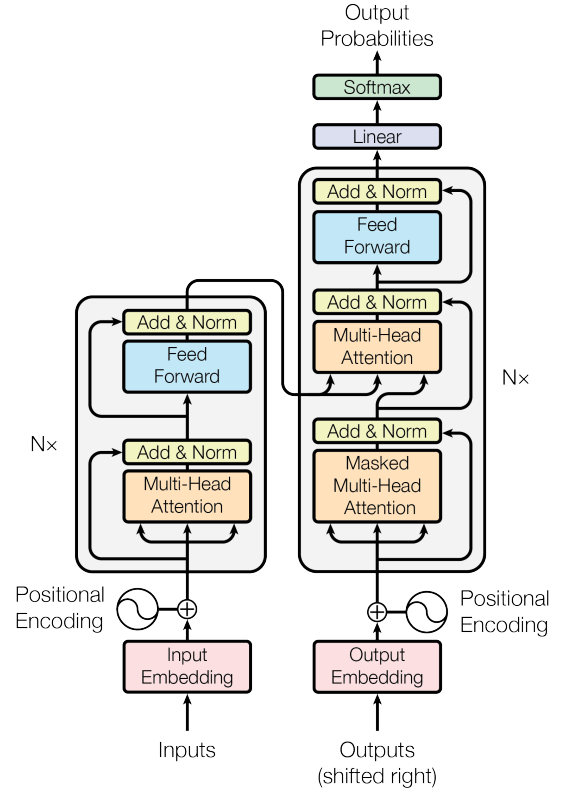

In [36]:
Image("images/Transformer.png", width="50%")

### Интерпретация Feed Forward слоев в Transformer

Рассмотрим `Feed Forward` слои: 

$$2FF \left(X\right) = ReLU \left(X \, W_1  + b_1 \right) W_2 + b_2$$
    
$W_1 \in \mathbb{R}^{d_{model} \,\times\, 4 d_{model}},$ $\quad$ $W_2 \in \mathbb{R}^{4 d_{model} \,\times\, d_{model}}$ $-$ обучаемые матрицы весов.
    
$b_1 \in \mathbb{R}^{4 d_{model}},$ $\quad$ $b_2 \in \mathbb{R}^{d_{model}}$ $-$ обучаемые векторы смещении, которые применяются к каждой строке матрицы.

Для упрощения опустим смещения $b_1$ и $b_2$. Тогда получим:

$$2FF \left(X\right) = ReLU \left(X \, W_1\right) W_2$$ 

> В этой интерпретации **столбцы** матрицы $W_1$ выступают в роли **ключей**, распознающих паттерны во входных данных, а **строки** матрицы $W_2$ $-$ это **значения**, которые добавляются в выходной вектор, если соответствующий ключ был активирован.

Можно заменить:

- $X\,\,\, \implies Q$ $\newline$

- $W_1 \implies K$ $\newline$

- $W_2 \implies V$ $\newline$

Получим формулу:

$$2FF \left(Q\right) = ReLU \left(Q \, K\right) V$$ 

Эта формула удивительным образом похожа на формулу:

$$SDPA = Softmax\left(\frac{Q K^T}{\sqrt{d}}\right) \cdot V$$

Мы убрали смещения, но интерпретация с ними была бы такой же. Смещение $b_1$ играет лишь роль порога активации, например, если $b_1$ имеет отрицательное значение, то ключ активируется только тогда ($ReLU$ зануляет все, что меньше 0), когда сходство $x$ и $k_i$ достаточно сильное, чтобы преодолеть отрицательное смещение. А $b_2$ просто добавляет некое базовое смещение к итоговому вектору независимо от входа.

В **[статье](https://www.alphaxiv.org/abs/2012.14913?chatId=019bb346-4a06-7e84-8910-f9e46f42c0fa)** говорится, что полносвязные слои в Трансформере работают как **Key-Value память**. Как и в $SDPA$ у нас есть набор ключей и значений. Для каждого запроса вычисляется сходство (вес) с каждым ключом. Полученные веса используются для вычисления взвешенной суммы векторов значений. Разница с SDPA в том, что сходства или веса (скалярное произведение) получаются ненормализованными, так как используется $ReLU$, а не $Softmax$. Также разница в том, что в $SDPA$ ключи и значения меняются от того, какие входные данные мы подаем, а ключи и значения в полносвязных слоях остаются теми же самыми, так как фактически это обучаемые параметры нейросети.

> Таким образом, слои Attention отвечают за понимание контекста (связи слов друг с другом в моменте), а слои Feed Forward выступают в роли долговременной памяти модели, хранящей факты и паттерны, выученные на этапе тренировки.

В этой же **[статье](https://www.alphaxiv.org/abs/2012.14913?chatId=019bb346-4a06-7e84-8910-f9e46f42c0fa)** рассказывается про интерпретацию Feed Forward слоев.

### Реализация Transformer с нуля

**Важный момент в реализации `MultiHeadAttention`:**

В теории можно было бы реализовать его так:

```python
result = []
for SDPA in self.heads:
    result.append(SDPA(Q, K, V))
            
result = torch.concat(result, dim=-1)
result = result @ self.W_O
```

Но при таком подходе используется медленный Python цикл, который сильно замедляет скорость работы нейросети. Тот же результат можно получить с помощью тензорных операции, которые работают в разы быстрее.

Для этого матрицы весов размера $[d_{model}, \frac{d_{model}}{h}]$ со всех голов можно объединить в один тензор размера $[d_{model}, d_{model}]$:

$$W^{(Q \text{ или } K \text{ или } V)} = \begin{pmatrix}
\color{blue}{W_{1,\,1}} & \dots & \color{blue}{W_{1,\,{\frac{d_{model}}{h}}}} & \color{red}{W_{1,\,{\frac{d_{model}}{h}+1}}} & \dots & \color{red}{W_{1,\, 2{\frac{d_{model}}{h}}}} & \dots & \color{orange}{W_{1,\,(h-1){\frac{d_{model}}{h}+1}}} & \dots & \color{orange}{W_{1,\, d_{model}}} \\
\color{blue}{W_{2, \,1}} & \dots & \color{blue}{W_{2, \,{\frac{d_{model}}{h}}}} & \color{red}{W_{2,\,{\frac{d_{model}}{h}+1}}} & \dots & \color{red}{W_{2,\, 2{\frac{d_{model}}{h}}}} & \dots & \color{orange}{W_{2,\,(h-1){\frac{d_{model}}{h}+1}}} & \dots & \color{orange}{W_{2,\, d_{model}}} \\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots & \dots & \vdots & \ddots & \vdots \\
\color{blue}{W_{d_{model}, \,1}} & \dots & \color{blue}{W_{d_{model}, \,{\frac{d_{model}}{h}}}} & \color{red}{W_{d_{model},\,{\frac{d_{model}}{h}+1}}} & \dots & \color{red}{W_{d_{model},\, 2{\frac{d_{model}}{h}}}} & \dots & \color{orange}{W_{d_{model},\,(h-1){\frac{d_{model}}{h}+1}}} & \dots & \color{orange}{W_{d_{model},\, d_{model}}} \\
\end{pmatrix}
$$

При умножении матрицы $W^{(Q \text{ или } K \text{ или } V)}$ на $Q, K$ или $V$ получаем, что строки $Q, K$ или $V$ умножаются на столбцы $W$.

Получаем, что для каждой головы матрицы считаются независимо.

Размерность каждой матрицы после $X \cdot W$, где $X$ $=$ $Q, K$ или $V$: `[Batch, Seq_len, d_model]`.

По оси `d_model` расположены оси голов $h$ и оси самих векторов этих голов размерности $\frac{d_{model}}{h}$. 

Стоит задача их разделить с помощью `view` и `transpose(1, 2)`:

`[Batch, Seq_len, d_model]` $→$ `[Batch, Seq_len, h, d_k]` $→$ `[Batch, h, Seq_len, d_k]`.

Пример, как это происходит: 

In [276]:
batch_size = 2
seq_len = 3
d_model = 6
h = 2
x = torch.arange(1, 37).view((batch_size, seq_len, d_model))

### Вдоль последней оси: 2 головы с размерностью векторов = 3

In [278]:
x  # [2, 3, 6]

tensor([[[ 1,  2,  3,  4,  5,  6],
         [ 7,  8,  9, 10, 11, 12],
         [13, 14, 15, 16, 17, 18]],

        [[19, 20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29, 30],
         [31, 32, 33, 34, 35, 36]]])

In [279]:
x = x.view((batch_size, seq_len, h, d_model // h))

### Предпоследняя ось – головы, последняя ось – векторы

Например, ось 

```python
[1,  2,  3,  4,  5,  6]
```

разделяется на 2 головы `[1,  2,  3]` и `[4,  5,  6]`:

```python
[[ 1,  2,  3],
 [ 4,  5,  6]]
```

Вместо оси `[d_model] = [6]` становится `[h, d_k] = [2, 3]`

In [281]:
x  # [2, 3, 2, 3]

tensor([[[[ 1,  2,  3],
          [ 4,  5,  6]],

         [[ 7,  8,  9],
          [10, 11, 12]],

         [[13, 14, 15],
          [16, 17, 18]]],


        [[[19, 20, 21],
          [22, 23, 24]],

         [[25, 26, 27],
          [28, 29, 30]],

         [[31, 32, 33],
          [34, 35, 36]]]])

### `[Batch, Seq_len, h, d_k]` $→$ `[Batch, h, Seq_len, d_k]`

Конкретно для данного примера получаем: всего в батче 2 элемента, в каждом элементе батча по 2 головы, в каждой голове 3 вектора последовательности, каждый вектор состоит из 3 элементов.

In [283]:
x.transpose(1, 2)  # [2, 2, 3, 3]

tensor([[[[ 1,  2,  3],
          [ 7,  8,  9],
          [13, 14, 15]],

         [[ 4,  5,  6],
          [10, 11, 12],
          [16, 17, 18]]],


        [[[19, 20, 21],
          [25, 26, 27],
          [31, 32, 33]],

         [[22, 23, 24],
          [28, 29, 30],
          [34, 35, 36]]]])

Далее для полученных тензоров размерности `[Batch, h, Seq_len, d_k]` применяется метод `torch.matmul`, который перемножает матрицы по батчам. При таком подходе первые $N-2$ размерностей будут размерностями батчей, а последние 2 размерности будут размерностями матриц, которые участвуют в перемножений.

Например, для тензоров $X$ и $Y$ размерностей $[1, 2, 2, 10]$ и $[1, 2, 10, 5]$ первые 2 размерности это размерности батчей. 

Это равносильно двойному циклу по первым 2 размерностям, при котором соответствующие матрицы перемножаются:


In [292]:
result = torch.zeros((1, 2, 2, 5))
Q = torch.rand(1, 2, 2, 10)
K = torch.rand(1, 2, 10, 5)
for b in range(1):         # Пробегаем по первому измерению
    for i in range(2):     # Пробегаем по второму измерению 
        # Берем матрицу [2, 10]
        mat1 = Q[b, i, :, :] 
        
        # Берем матрицу [10, 5]
        mat2 = K[b, i, :, :]
        
        # Перемножаем матрицы. Получаем матрицу [2, 5]
        result[b, i, :, :] = mat1 @ mat2

In [293]:
result

tensor([[[[1.4095, 2.9855, 2.0520, 1.5533, 1.8009],
          [2.4464, 3.7827, 3.1325, 2.4231, 2.1529]],

         [[3.0475, 3.4625, 3.0413, 2.5462, 3.3550],
          [2.7671, 4.2014, 4.6693, 2.8607, 3.8754]]]])

In [294]:
torch.matmul(Q, K)

tensor([[[[1.4095, 2.9855, 2.0520, 1.5533, 1.8009],
          [2.4464, 3.7827, 3.1325, 2.4231, 2.1529]],

         [[3.0475, 3.4625, 3.0413, 2.5462, 3.3550],
          [2.7671, 4.2014, 4.6693, 2.8607, 3.8754]]]])

In [295]:
result.shape

torch.Size([1, 2, 2, 5])

Получаем одинаковый результат. В этом и заключается сила тензорных операции: мы прошлись по циклу без использования Python циклов.

### Разница между `nn.Parameter`, `self.register_buffer` и обычным атрибутом.

| Характеристика | `nn.Parameter` | `register_buffer` | Обычный атрибут (`self.x = Tensor`) |
| :--- | :--- | :--- | :--- |
| **Основное назначение** | **Веса, которые нужно обучать** | **Состояние, которое нужно хранить, но не обучать** | **Временные данные или константы, не зависящие от устройства** |
| **Виден оптимизатору?**<br>*(model.parameters())* | **Да** | **Нет** | **Нет** |
| **Сохраняется в файл?**<br>*(state_dict)* | **Да** | **Да** | **Нет** |
| **Работает `.to(device)`?** | **Да** | **Да** | **Нет** *(останется на CPU)* |
| **Градиент (`requires_grad`)** | **По умолчанию `True`** | **По умолчанию `False`** | **Зависит от создания тензора** |
| **Пример использования** | **Веса Linear, Conv2d** | **BatchNorm running_mean, Positional Encoding** | **Гиперпараметры (int, float), временные кэши** |

### Маски в Трансформере:

**Маски Энкодера.**

В Энкодере используются Self-Attention блоки. Это значит, что каждый токен (строка) смотрит на все остальные токены (столбцы). 
Если последние токены $-$ это паддинг, модель не должна их видеть. Для этого используются маски.

Представим батч из 1 примера. Длина последовательности 5, реальных слов 3: `[A, B, C, <PAD>, <PAD>]`.

Маска будет выглядеть так (где `1` $-$ можно смотреть, `0` $-$ нельзя):

$$
\begin{pmatrix}
1 & 1 & 1 & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0}
\end{pmatrix}
$$

Эта маска накладывается на матрицу внимания $\frac{Q K^T}{\sqrt{d}}$, причем для каждого батча будет своя маска. Для тех элементов маски, у которых значение равно `0`, значение в матрице внимания заменяется на $- \infty$. После $Softmax$ на этих местах будут нули и паддинг токены не будут влиять на результат.

- **По строкам:** Кто смотрит (Query). Паддинг-токены (последние 2 строки) что-то вычисляют, но их результат потом отбросится. $\newline$

- **По столбцам:** На кого смотрят (Key). Столбцы 4 и 5 занулены для всех.

Применение Padding масок позволяет не учитывать padding токены при вычислений взвешенной суммы векторов значений. 

---

**Маски Декодера.**

В декодере 2 блока `Multi-Head Attention`: `Cross Attention` и `Masked Self-Attention`.

**Рассмотрим `Masked Self-Attention`:**

Декодеру нужно соблюсти два условия одновременно:

1.  Не смотреть в будущее (треугольная маска). $\newline$

2.  Не смотреть на паддинг токены (паддинг маска).

Итоговая маска $-$ это **пересечение** (логическое И) этих двух масок.

Представим батч из 1 примера. Длина последовательности 5, реальных слов 3: `[A, B, C, <PAD>, <PAD>]`.

**1. Треугольная маска:**
$$
\begin{pmatrix}
1 & \color{blue}{0} & \color{blue}{0} & \color{blue}{0} & \color{blue}{0} \\
1 & 1 & \color{blue}{0} & \color{blue}{0} & \color{blue}{0} \\
1 & 1 & 1 & \color{blue}{0} & \color{blue}{0} \\
1 & 1 & 1 & 1 & \color{blue}{0} \\
1 & 1 & 1 & 1 & 1
\end{pmatrix}
$$

**2. Padding маска:**
$$
\begin{pmatrix}
1 & 1 & 1 & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0}
\end{pmatrix}
$$

**3. Итоговая маска (A & B):**
$$
\begin{pmatrix}
1 & \color{blue}{0} & \color{blue}{0} & \color{red}{0} & \color{red}{0} \\
1 & 1 & \color{blue}{0} & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0} \\
1 & 1 & 1 & \color{red}{0} & \color{red}{0}
\end{pmatrix}
$$

Такая маска позволяет одновременно не подглядывать в будущее и не учитывать padding токены при вычислений результата.

**Теперь рассмотрим `Cross Attention`:**

Для этого блока нужна **Padding маска Энкодера** чтобы Декодер не обращал внимания на padding токены во входной последовательности в Энкодер. 

`Cross Attention` **не нужна треугольная маска**. Это связно с тем, что:

- Запросы (Q) идут от Декодера. $\newline$

- Ключи (K) идут от Энкодера.

Здесь нам не нужна треугольная маска, так как мы можем смотреть на все токены входной последовательности, которая подается в Энкодер.

---

### KV Cache

`KV Cache` $-$ это механизм кэширования промежуточных вычислений в Декодере трансформеров, который сохраняет ключи (Key) и значения (Value) для всех предыдущих токенов во время инференса. Без `KV Cache` модель вынуждена была бы пересчитывать матрицы Key и Value для всей последовательности при генерации каждого нового токена. Такой подход снижает вычислительную сложность Attention с квадратичной $O(N^2)$ до линейной $O(N)$ на каждом шаге генерации.

**Математика процесса**

Пусть мы находимся на шаге генерации $t$.
Это значит, что токены $x_1, \dots, x_{t-1}$ уже обработаны.
На вход подается **только один** токен $x_t$.

У нас есть сохраненные тензоры (Кэш) с предыдущих шагов:
- $K_{cache}^{(t-1)}$ размерности `[batch, steps, d_model]` = `[1, t-1, d_model]` (или `[batch, heads, t-1, d_k]`). $\newline$

- $V_{cache}^{(t-1)}$ той же размерности.

**Алгоритм внутри слоя Multi-Head Attention:**

1.  **Проекция текущего токена:**
    
    Мы берем вектор текущего токена $x_t$ (размерность $[1, d_{model}]$) и умножаем на матрицы весов $W_Q, W_K, W_V$.
    
    $$ q_t = x_t W_Q \quad \text{(размер } 1 \times d_k \text{)} $$
    
    $$ k_t = x_t W_K \quad \text{(размер } 1 \times d_k \text{)} $$
    
    $$ v_t = x_t W_V \quad \text{(размер } 1 \times d_k \text{)} $$
    
    Мы вычислили $k$ и $v$ только для одного токена. $\newline$

2.  **Обновление Кэша:**

    Мы добавляем новые $k_t$ и $v_t$ в Кэш.
    
    $$ K_{new} = \text{Concat}\left(K_{cache}^{(t-1)}, k_t\right) \quad \implies \text{размер } [t, d_k] $$
    
    $$ V_{new} = \text{Concat}\left(V_{cache}^{(t-1)}, v_t\right) \quad \implies \text{размер } [t, d_k] $$
    
    Теперь $K_{new}$ содержит ключи для всех токенов от 1 до $t$. Мы сохраняем этот новый кэш для следующего шага. $\newline$

3.  **Вычисление матрицу внимания:**

    В обучении мы умножаем матрицу $Q$ (все токены) на $K^T$ (все токены).
    Здесь у нас $Q$ $-$ это только **один** вектор $q_t$.
    
    $$ \text{Scores} = \frac{q_t \cdot (K_{new})^T}{\sqrt{d_k}} $$
    
    Размерности:
    $$ [1, d_k] \times [d_k, t] = [1, t] $$
    
    Мы получили вектор оценок длиной $t$. Этот вектор означает, как сильно текущий токен $t$ смотрит на токен 1, на токен 2, ..., на токен $t$. $\newline$

4.  **Softmax и взвешенная сумма:**
    
    $$ \text{Weights} = \text{Softmax}(\text{Scores})$$
    
    $$ \text{Output}_t = \text{Weights} \cdot V_{new} $$
    
    Размерности:
    
    $$ [1, t] \times [t, d_k] = [1, d_k] $$

**Такие пары кэшей $(K, V)$ сохраняются для каждого слоя Декодера в Трансформере.** Например, если в Декодере Трансформера 6 слоев, то у нас 6 пар кэшей $(K, V)$.

**Полезное свойство KV Cache**:

- При использовании **KV Cache треугольная маска не нужна**, чтобы спрятать токены $t+1, t+2 \dots$ от токена $t$.
В режиме KV Cache у нас в кэше лежат ключи и значения только от $1$ до $t-1$ шага, и мы только что посчитали ключ и значение для $t$. Ключей для следующих шагов физически не существует в памяти. Токену $t$ просто некуда подглядывать. Маскировка происходит автоматически.

---

### Обоснование умножения эмбеддингов на $\sqrt{d_{model}}$

В архитектуре Transformer входной вектор $X$ формируется так:

$$ X = E \cdot \sqrt{d_{model}} + PE $$

Для стабильности обучения нейросетей (предотвращения затухания/взрыва градиентов) веса инициализируются так, чтобы сохранять дисперсию сигнала при проходе через слои.

Эмбеддинги $E = [e_1, e_2, ..., e_d]$ имеют такие характеристики:

$$ \mathbb{E}\left[e_i\right] = 0 $$

$$ \text{Var}\left(e_i\right) = \frac{1}{d_{model}} $$

Рассчитаем ожидаемый квадрат нормы вектора эмбеддинга **без умножения** на $\sqrt{d_{model}}$:

$$ \mathbb{E}\left[\|E\|^2\right] = \mathbb{E}\left[\sum_{i=1}^{d_{model}} e_i^{\,2}\right] = \sum_{i=1}^{d_{model}} \mathbb{E}[e_i^{\,2}] = d_{model} \cdot \frac{1}{d_{model}} = 1$$

Так как $\text{Var}\left(X\right) = \mathbb{E}\left[X^2\right] - \left(\mathbb{E}\left[X\right]\right)^{\,2}$, то $\mathbb{E}\left[e_i^{\,2}\right] = \text{Var}\left( e_i \right) + \left(\mathbb{E}\left[e_i\right]\right)^{\,2} = \text{Var}\left( e_i \right) = \frac{1}{d_{model}}$.

**Вывод:** Без умножения на $\sqrt{d_{model}}\,$ вектор эмбеддинга имеет длину (квадрат нормы) близкую к **1**.

Рассмотрим теперь позиционный вектор. Его элементы состоят из значений синусов и косинусов. Мы можем рассматривать их как равномерно распределенные случайные величины.

Среднее значение квадрата синуса (или косинуса) за период:

$$\mathbb{E}\left[p_i^{\,2}\right] \approx \frac{1}{2\pi} \int_0^{2\pi} \sin^2(x) dx = \frac{1}{2} $$

Теперь рассчитаем ожидаемую норму вектора $PE$:

$$ \mathbb{E}\left[\|PE\|^2\right] = \sum_{i=1}^{d_{model}} \mathbb{E}\left[p_i^{\,2}\right] = d_{model} \cdot 0.5 = \frac{d_{model}}{2} $$

**Вывод:** Вектор позиционного кодирования имеет длину (квадрат нормы) порядка **$\frac{d_{model}}{2}$**.

Видно, что нормы сильно различаются. Теперь рассмотрим квадрат нормы **после умножения** на $\sqrt{d_{model}}$:

$$\mathbb{E}\left[\hat{e}_i^{\,2}\right] = \text{Var}\left(\hat{e}_i\right) = \text{Var}\left(e_i \cdot \sqrt{d_{model}}\, \right) = \left(\sqrt{d_{model}}\, \right)^2 \cdot \text{Var}\left(e_i\right) = d_{model} \cdot \frac{1}{d_{model}} = 1$$

$$ \mathbb{E}\left[\|\hat{E}\|^2\right] = \sum_{i=1}^{d_{model}} \mathbb{E}\left[\hat{e}_i^{\,2}\right] = d_{model} \cdot 1 = d_{model} $$

Теперь ожидаемые нормы имеют **один порядок величины** $d_{model}$:

$$ \frac{\|\hat{E}\|^2}{\|PE\|^2} \approx \frac{d_{model}}{0.5 \cdot d_{model}} = 2 $$

**Зачем было рассматривать квадрат нормы векторов эмбеддингов?**

Все дело в Self-Attention и в скалярном произведении запроса и ключа: $Q \cdot K^T$.

$$ x_i \cdot x_j = (\hat{E}_i + PE_i) \cdot (\hat{E}_j + PE_j) $$

$$ x_i \cdot x_j = \underbrace{\hat{E}_i \cdot \hat{E}_j}_{\text{Смысл}} + \underbrace{(\hat{E}_i \cdot PE_j + PE_i \cdot \hat{E}_j)}_{\text{Смесь}} + \underbrace{PE_i \cdot PE_j}_{\text{Позиция}} $$

**Сценарий без $\sqrt{d_{model}}$ :**

- Вклад $\mathbb{E}\left[E \cdot E\, \right] \approx 1$. $\newline$

- Вклад $\mathbb{E}\left[PE \cdot PE\, \right] \approx \frac{d_{model}}{2}$. $\newline$

- **Итог:** Вклад слагаемого позиции значительно больше слагаемое смысла. 

**Сценарий с $\sqrt{d_{model}}$ :**

- Вклад $\mathbb{E}\left[\hat{E} \cdot \hat{E} \, \right] \approx d_{model}$. $\newline$

- Вклад $\mathbb{E}\left[PE \cdot PE \, \right] \approx \frac{d_{model}}{2}$. $\newline$

- **Итог:** Оба слагаемых сопоставимы. Градиенты могут эффективно обновлять веса $E$, так как семантическая часть вносит значимый вклад в итоговое значение скалярного произведения.

---

### Лучшие практики обучения Transformer

1. Использование `Learning Rate Warmup` и `Linear / Cosine annealing`. $\newline$

2. Использование инициализации `Xavier`, обучаемые параметры `bias = 0`, обучаемые параметры масштабирования в `LayerNorm` инициализируются `1`.

    Также часто в глубоких Трансформерах применяется дополнительное умножение некоторых весов на $\frac{1}{\sqrt{N}}$, где $N$ $-$ число остаточных (residual) соединений. Например, если в модели Энкодера $L$ слоев, то $N = 2 \times L$, так как в каждом слое 2 остаточных соединения (одно после Attention, другое после Feed-Forward слоев).
    
    Такое масштабирование применяется:
    
    - Для блока `Multi-Head Attention` к матрице $W_O$. $\newline$
    
    - Для блока `Feed-Forward` слоев к весам второго линейного слоя. 
    
    В глубоких сетях с `Pre-LayerNorm` (как GPT-2) дисперсия сигнала растет по мере прохождения слоев, так как каждый слой что-то добавляет к входу ($x + f(x)$). Умножая веса на $\frac{1}{\sqrt{N}}$, мы уменьшаем выход каждого отдельного слоя, чтобы сумма всех $N$ слоев не приводила к взрывному росту значений активаций в начале обучения. $\newline$
    
3. Использование `GELU` вместо `ReLU`. 

    Математическое определение GELU выглядит так:

    $$ \text{GELU}\left(x\right) = x \cdot P\left(X \le x\right) = x \cdot \Phi\left(x\right) $$
    
    - $x$ $-$ входное значение $\newline$
    
    - $\Phi\left(x\right)$ $-$ функция распределения стандартного нормального распределения $\mathcal{N}(0, 1)$

    Мы умножаем вход $x$ на вероятность того, что случайная величина из нормального распределения будет меньше $x$. $\newline$
    
4. Использование `Pre-LN` вместо `Post-LN` (в оригинальном Трансформере).

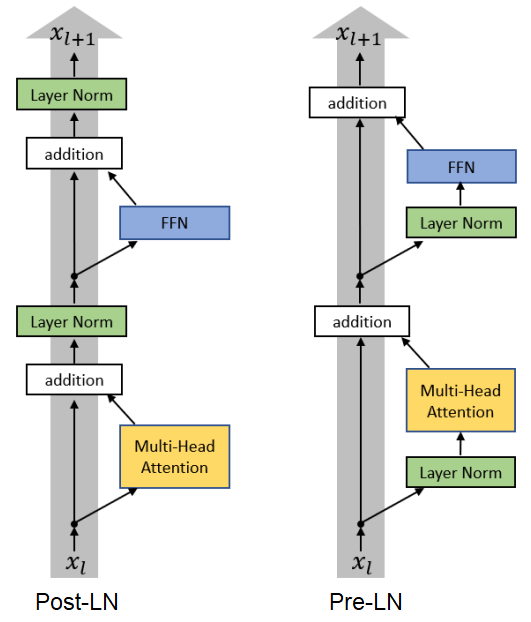

In [4]:
Image("images/Pre-LN.png", width="30%")

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, h, dropout_p=0.1):
        super().__init__()
        self.d_model = d_model
        self.h = h
        self.d_k = d_model // h

        self.W_O = nn.Parameter(
            nn.init.xavier_normal_(
                torch.randn(d_model, d_model)
            )
        )
        
        self.W_Q = nn.Parameter(
            nn.init.xavier_normal_(
                torch.randn(d_model, d_model)
            )
        )
       
        self.W_K = nn.Parameter(
            nn.init.xavier_normal_(
                torch.randn(d_model, d_model)
            )
        )
    
        self.W_V = nn.Parameter(
            nn.init.xavier_normal_(
                torch.randn(d_model, d_model)
            )
        )

        self.dropout = nn.Dropout(dropout_p)
        self.kv_cache = None
        
    def forward(self, Q, K, V, mask=None, cache=False):
        """
        Q:     [Batch, Seq_len1, d_model]
        K, V:  [Batch, Seq_len2, d_model]
        mask:  [Batch, Seq_len1, Seq_len2]
        """
            
        Q_heads = Q @ self.W_Q    # [Batch, Seq_len1, d_model]
        K_heads = K @ self.W_K    # [Batch, Seq_len2, d_model]
        V_heads = V @ self.W_V    # [Batch, Seq_len2, d_model]

        if cache:
            if self.kv_cache is not None:
                K_cached = torch.concat([self.kv_cache[0], K_heads], dim=1)
                V_cached = torch.concat([self.kv_cache[1], V_heads], dim=1)
            else:
                K_cached = K_heads
                V_cached = V_heads
                
            self.kv_cache = (K_cached, V_cached)
            K_heads = K_cached
            V_heads = V_cached
        
        # [Batch, Seq_len, d_model] -> [Batch, Seq_len, h, d_k] -> [Batch, h, Seq_len, d_k]
        Q_heads = Q_heads.view(Q_heads.shape[0], Q_heads.shape[1], self.h, self.d_k).transpose(1, 2)
        K_heads = K_heads.view(K_heads.shape[0], K_heads.shape[1], self.h, self.d_k).transpose(1, 2)
        V_heads = V_heads.view(V_heads.shape[0], V_heads.shape[1], self.h, self.d_k).transpose(1, 2)
        
        # [Batch, h, Seq_len1, Seq_len2]
        attention_maps = torch.matmul(Q_heads, K_heads.transpose(-1, -2)) / math.sqrt(self.d_k)
        if mask is not None:
            mask = mask.unsqueeze(1)                               # [Batch, 1, Seq_len1, Seq_len2]
            attention_maps.masked_fill_(mask == 0, -1e9)
            
        attention_weights = torch.softmax(attention_maps, dim=-1)  # [Batch, h, Seq_len1, Seq_len2]
        attention_weights = self.dropout(attention_weights)
        
        scores = torch.matmul(attention_weights, V_heads)          # [Batch, h, Seq_len1, d_k]
        scores = scores.transpose(1, 2).contiguous()               # [Batch, Seq_len1, h, d_k]
        scores = scores.view(scores.shape[0],                      # [Batch, Seq_len1, d_model]
                             scores.shape[1], 
                             self.d_model)
        
        result = scores @ self.W_O                                 # [Batch, Seq_len1, d_model]  
        
        return result

    def clear_cache(self):
        self.kv_cache = None
    
    
class LayerNorm(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(size))
        self.bias = nn.Parameter(torch.zeros(size))
        
    def forward(self, X, eps=1e-6):
        """
        X: [Batch, Seq_len, size]
        """
        mean = X.mean(dim=-1, keepdim=True)              # [Batch, Seq_len, 1]  [1] в конце благодаря keepdim=True
        var = X.var(dim=-1, correction=0, keepdim=True)  # [Batch, Seq_len, 1]  который сохраняет размерность
        
        return self.gamma * (X - mean) / torch.sqrt(var + eps) + self.bias
    

class FeedForwardLayers(nn.Module):
    def __init__(self, d_model, dropout_p=0.1):
        super().__init__()
        self.d_model = d_model
        self.layer1 = nn.Linear(d_model, 4 * d_model)
        self.layer2 = nn.Linear(4 * d_model, d_model)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout_p)
        
    def forward(self, X):
        """
        X: [Batch, Seq_len, d_model]
        """
        out = self.act(self.layer1(X))
        out = self.dropout(out)
        out = self.layer2(out)
        
        return out
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        pe = torch.zeros(max_seq_len, d_model)
        pos = torch.arange(0, max_seq_len).unsqueeze(1).expand(max_seq_len, d_model // 2)  # [max_seq_len, d_model // 2]
        i = torch.arange(0, d_model//2).unsqueeze(0).expand(max_seq_len, d_model//2)       # [max_seq_len, d_model // 2]
        arg = pos / 10000**(2 * i / d_model)
        pe[:, ::2] = torch.sin(arg)
        pe[:, 1::2] = torch.cos(arg)
        
        pe = pe.unsqueeze(0)            # [1, max_seq_len, d_model]
        self.register_buffer("pe", pe)
        
    def forward(self, X):
        """
        X: [Batch, Seq_len, d_model] or int
        """
        if isinstance(X, int):
            out = self.pe[:, X, :]
        else:
            out = X + self.pe[:, :X.shape[1], :]
        return out


class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, X):
        out = self.embedding(X) * math.sqrt(self.d_model)
        return out

In [3]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, h, dropout_p=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, h, dropout_p)
        self.norm1 = LayerNorm(d_model)
        self.ff = FeedForwardLayers(d_model, dropout_p)
        self.norm2 = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout_p)
        
    def forward(self, X, padding_mask=None):
        """
        X:            [Batch, Seq_len, d_model]
        padding_mask: [Batch, 1, Seq_len]
        """
        out = self.norm1(X)                                # [Batch, Seq_len, d_model]
        out = self.mha(out, out, out, mask=padding_mask)   # [Batch, Seq_len, d_model]
        out = self.dropout(out)
        out = out + X

        norm_out = self.norm2(out)                         # [Batch, Seq_len, d_model]
        ff_out = self.ff(norm_out)                         # [Batch, Seq_len, d_model]
        ff_out = self.dropout(ff_out)
        out = ff_out + out      
        
        return out
    

class Encoder(nn.Module):
    def __init__(self, d_model, h, num_layers, dropout_p=0.1):
        super().__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList(
            EncoderLayer(d_model, h, dropout_p) for _ in range(num_layers)
        )
        self.norm = LayerNorm(d_model)
        
    def forward(self, X, padding_mask=None):
        """
        X:            [Batch, Seq_len, d_model]
        padding_mask: [Batch, 1, Seq_len]
        """
        for layer in self.layers:
            X = layer(X, padding_mask)
            
        return self.norm(X)
    

class DecoderLayer(nn.Module):
    def __init__(self, d_model, h, dropout_p=0.1):
        super().__init__()
        self.masked_mha = MultiHeadAttention(d_model, h, dropout_p)
        self.norm1 = LayerNorm(d_model)
        self.cross_mha = MultiHeadAttention(d_model, h, dropout_p)
        self.norm2 = LayerNorm(d_model)
        self.ff = FeedForwardLayers(d_model, dropout_p)
        self.norm3 = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout_p)
        
    def forward(self, X, X_enc, enc_mask=None, dec_mask=None, cache=False):
        """
        X:        [Batch, Seq_len1, d_model]
        X_enc:    [Batch, Seq_len2, d_model]
        enc_mask: [Batch, 1, Seq_len2]
        dec_mask: [Batch, Seq_len1, Seq_len1]
        """
        norm_out = self.norm1(X)                                 # [Batch, Seq_len1, d_model]
        out = self.masked_mha(norm_out,                          # [Batch, Seq_len1, d_model]
                              norm_out, 
                              norm_out, dec_mask, cache=cache)       
        out = self.dropout(out)
        out = out + X

        norm_out = self.norm2(out)                               # [Batch, Seq_len1, d_model]
        cross_mha_out = self.cross_mha(norm_out,                 # [Batch, Seq_len1, d_model]
                                       X_enc, 
                                       X_enc, enc_mask, cache=False)    
        cross_mha_out = self.dropout(cross_mha_out)
        out = cross_mha_out + out

        norm_out = self.norm3(out)                               # [Batch, Seq_len1, d_model]
        ff_out = self.ff(norm_out)                               # [Batch, Seq_len1, d_model]
        ff_out = self.dropout(ff_out)
        out = ff_out + out
        
        return out

    def clear_cache(self):
        self.masked_mha.clear_cache()
    

class Decoder(nn.Module):
    def __init__(self, d_model, h, num_layers, dropout_p=0.1):
        super().__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList(
            DecoderLayer(d_model, h, dropout_p) for _ in range(num_layers)
        )
        self.norm = LayerNorm(d_model)
        
    def forward(self, X, X_enc, enc_mask=None, dec_mask=None, cache=False):
        """
        X:        [Batch, Seq_len1, d_model]
        X_enc:    [Batch, Seq_len2, d_model]
        enc_mask: [Batch, 1, Seq_len2]
        dec_mask: [Batch, Seq_len1, Seq_len1]
        """
        for layer in self.layers:
            X = layer(X, X_enc, enc_mask, dec_mask, cache=cache)
            
        return self.norm(X)

    def clear_cache(self):
        for layer in self.layers: 
            layer.clear_cache()
            
    
class Transformer(nn.Module):
    def __init__(self, d_model, h, enc_num_layers, dec_num_layers, vocab_size, max_seq_len, dropout_p=0.1):
        super().__init__()
        self.enc_num_layers = enc_num_layers
        self.dec_num_layers = dec_num_layers
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.pe = PositionalEncoding(d_model, max_seq_len)
        self.encoder = Encoder(d_model, h, enc_num_layers, dropout_p)
        self.decoder = Decoder(d_model, h, dec_num_layers, dropout_p)
        self.dropout = nn.Dropout(dropout_p)
        self.embedding = Embedding(vocab_size, d_model)
        nn.init.xavier_normal_(self.embedding.embedding.weight)
        self.projection_layer = nn.Linear(d_model, vocab_size)
        self.projection_layer.weight = self.embedding.embedding.weight
        
    def forward(self, X_enc, X_dec, enc_mask, dec_mask):
        """
        X_enc:      [Batch, Seq_len1]
        X_dec:      [Batch, Seq_len2]
        enc_mask:   [Batch, 1, Seq_len1]
        dec_mask:   [Batch, Seq_len2, Seq_len2]
        """
        X_enc = self.embedding(X_enc)                       # [Batch, Seq_len1, d_model]
        X_enc = self.pe(X_enc)                              # [Batch, Seq_len1, d_model]
        X_enc = self.dropout(X_enc)
        
        X_dec = self.embedding(X_dec)                       # [Batch, Seq_len2, d_model]
        X_dec = self.pe(X_dec)                              # [Batch, Seq_len2, d_model]
        X_dec = self.dropout(X_dec)
        
        out = self.encoder(X_enc, enc_mask)                 # [Batch, Seq_len1, d_model]
        out = self.decoder(X_dec, out, enc_mask, dec_mask)  # [Batch, Seq_len2, d_model]
        out = self.projection_layer(out)                    # [Batch, Seq_len2, vocab_size]
        
        return out

    def generate(self, X_enc, sos_id=1, eos_id=2, max_len=100):
        """
        X_enc:  [1, Seq_len1]
        """
        dec_id = torch.tensor([[sos_id]]).long().to(X_enc.device)  # [1, 1]
        X_enc = self.embedding(X_enc)                              # [1, Seq_len1, d_model]
        X_enc = self.pe(X_enc)                                     # [1, Seq_len1, d_model]
        enc_out = self.encoder(X_enc)                              # [1, Seq_len1, d_model]

        result = []
        i = 0
        while i < max_len:
            X_dec = self.embedding(dec_id)                         # [1, 1, d_model]
            X_dec = X_dec + self.pe(i)                             # [1, 1, d_model]
            out = self.decoder(X_dec, enc_out, cache=True)         # [1, 1, d_model]
            out = self.projection_layer(out)                       # [1, 1, vocab_size]
            dec_id = torch.argmax(out, dim=-1)                     # [1, 1]
            next_token = dec_id.item()
            result.append(next_token)
            if next_token == eos_id:
                break
            i += 1

        self.decoder.clear_cache()

        return result

In [13]:
model = Transformer(d_model=512, h=8, enc_num_layers=6, dec_num_layers=6, vocab_size=10, max_seq_len=1000)

In [14]:
model(torch.randint(1, 9, (2, 10)), 
      torch.randint(1, 9, (2, 5)), 
      torch.randint(0, 2, (2, 1, 10)), 
      torch.randint(0, 2, (2, 5, 5))).shape

torch.Size([2, 5, 10])

In [15]:
len(model.generate(torch.randint(1, 9, (1, 10)), max_len=10))

10